Проект: Когортный анализ в онлайн-ретейле.
В этом проекте я попробую провести исследование поведения пользователей британского интернет-магазина. Датасет брал с kaggle. Ссылка на датасет: https://www.kaggle.com/datasets/vijayuv/onlineretail/data
Датасет содержит информацию о заказах клиентов интернет магазина, включая номер счёта, артикул товара, описание, количество, дату заказа, цену, номер покупателя и страну.
Цель: Провести когортный анализ данных британского интернет-магазина, чтобы изучить поведение пользователей и сформулировать гипотезы для улучшения клиентского опыта и увеличения выручки.

## Прелюдия к EDA
Для начала импортируем все нужные библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

Считаем csv и преобразуем в датафрейм

In [2]:
df = pd.read_csv('/Users/reon/Desktop/OnlineRetail.csv', encoding='latin1')

## EDA
В этом разделе перед началом анализа данных посмотрим на структуру датасета поподробнее и приведем данные к удобному виду для дальнейшего анализа.

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Теперь посмотрим подробнее на содержанте таблицы. Узнаем типы данных, посмотрим количество ненулевых значений.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Как мы видим у нас много пустых ячеек в CustomerID. С этим что-то нужно делать. У нас два варианта: или заменить их на что-то, или удалить строки с ними. Я выберу второй вариант, потому что если мы заменим их допустим на 0 или какое-то другое значение, то у нас может возникнуть ситуация, что к уже существующим покупателям прибавятся ещё покупки, что создаст путаницу или у нас появится покупатель, у которого несколько десятков тысяч покупок, если мы на одинаковое значение заменим все пустые ячейки. 
Также у нас есть пропуски в Description, хотя они и не повлияют на формирование когорт, они могут повлиять на дальнейший анализ, так что удалим строки с ними. С остальными столбцами всё нормально.

In [5]:
df_cleaned = df.dropna().copy()

Преобразуем InvoiceDate из object в datetime.

In [6]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

Теперь избавимся от аномальных данных в цене и количестве.

In [7]:
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

Также стоит избавиться от дубликатов, потому что они будут мешать строить когорты.

In [8]:
df_cleaned = df_cleaned.drop_duplicates()

Добавим ещё несколько столбцов, которые позволят лучше и проще анализировать данные в будущем.

In [9]:
df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

Теперь добавим столбец с месяцем первой покупки

In [10]:
first_purchase_date = df_cleaned.groupby('CustomerID')['InvoiceDate'].min()
first_purchase_month = first_purchase_date.dt.to_period('M')
df_cleaned['FirstPurchaseMonth'] = df_cleaned['CustomerID'].map(first_purchase_month)

Посмотрим на результат того, как у нас изменилась таблица

In [11]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           392692 non-null  object        
 1   StockCode           392692 non-null  object        
 2   Description         392692 non-null  object        
 3   Quantity            392692 non-null  int64         
 4   InvoiceDate         392692 non-null  datetime64[ns]
 5   UnitPrice           392692 non-null  float64       
 6   CustomerID          392692 non-null  float64       
 7   Country             392692 non-null  object        
 8   TotalAmount         392692 non-null  float64       
 9   FirstPurchaseMonth  392692 non-null  period[M]     
dtypes: datetime64[ns](1), float64(3), int64(1), object(4), period[M](1)
memory usage: 33.0+ MB


Теперь хотель бы понять более подробно с чем мне предстоит работать. Покрутим данные с разных сторон, чтобы лучше понять их

Для начала поймём лучше масштаб того с чем предстоит работать. Для этого узнаем сколько у нас всего стран, пользователей, товаров.

In [13]:
total_countries = df_cleaned['Country'].nunique()
total_customers = df_cleaned['CustomerID'].nunique()
total_stock_code = df_cleaned['StockCode'].nunique()
print(f'Количество стран: {total_countries}' + '\n' + f'Количеств пользователей: {total_customers}'
      + '\n' + f'Количество товаров: {total_stock_code}')

Количество стран: 37
Количеств пользователей: 4338
Количество товаров: 3665


Теперь хотелось бы посмотреть на численные характеристики количества товаров, которые купили за раз, цены товара в покупке и общую сумму чека за покупку.

In [14]:
df_cleaned[['Quantity', 'UnitPrice', 'TotalAmount']].describe()

,Quantity,UnitPrice,TotalAmount
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


Видно, что тут довольно большой разброс значений. Пока не буду удалять или обрабатывать их, потому что они могут быть полезны для дальнейшего анализа и представлять из себя реальных пользователей. Но отметить это всё же стоит и также держать это у себя в голове для дальнейшего.

Вообще с учётом такого большого разброса интересно посмотреть на то, сколько пользователей, которые делают такие аномальные покупки, может быть, они чем-то выделяются и могут принести большую выгоду. Поэтому поcтроим графики для того, чтобы получше понять, как распределены величины.

Начнём с количества единиц товаров.

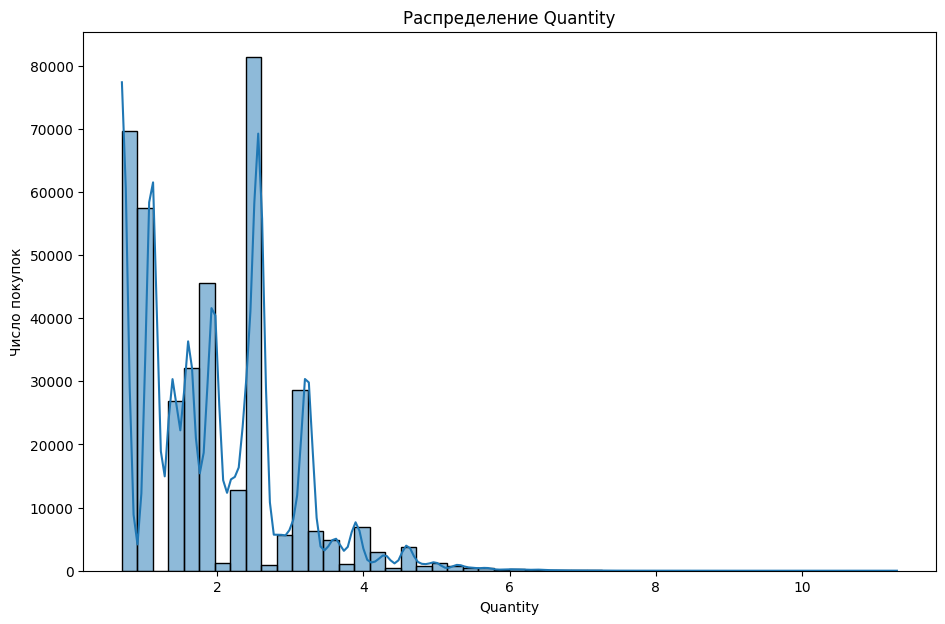

In [15]:
plt.figure(figsize=(11, 7))
sns.histplot(np.log1p(df_cleaned['Quantity']), bins=50, kde=True)
plt.title('Распределение Quantity')
plt.ylabel('Число покупок')
plt.show()

Когда мы строили график, то мы использовали np.log1p() для того, чтобы распределение было более наглядным. По распределению видно, что подавляющее количество находится до 6 после применения np.log1p(). Общее число операций очень велико и поэтому сложно посмотреть на распределение покупок с большим числом экземпляров. Посмотрим подробнее на операции с большим числом единиц товара. Но перед этим интересно узнать, как много таких чисел? Может их меньше чем 99-й процентиль. Если меньше, то тогда можем взять немного больше операций и клиентов и довести до 99 процентиля, потому что у нас всё же до 6 идёт уже мало операций и ещё 99-й процентиль гибче. Если же их уже больше, то так и оставим границу в виде 6.
Для начала поймем какому числу товаров за покупку равна 6.

In [16]:
quantity_border = np.round(np.expm1(6))
print(quantity_border)

402.0


Теперь сравним с процентилем и посмотрим, сколько у нас чисел более 99 процентиля и сколько более 402.

In [17]:
quantity_quantile_99 = df_cleaned['Quantity'].quantile(0.99)
big_quantity_with_border = df_cleaned['Quantity'][df_cleaned['Quantity'] >= quantity_border].count()
big_quantity_with_quantile_99 = df_cleaned['Quantity'][df_cleaned['Quantity'] >= quantity_quantile_99].count()
print(f'99-й процентиль: {quantity_quantile_99}' + '\n'
      + f'Количество покупок, где число единиц товара больше 99 процентиля: {big_quantity_with_quantile_99}'
      + '\n' + f'Количество покупок, где число единиц товара больше 402: {big_quantity_with_border}')

99-й процентиль: 120.0
Количество покупок, где число единиц товара больше 99 процентиля: 4487
Количество покупок, где число единиц товара больше 402: 633


Значит берём 99-й прецентиль по числу единиц товара за покупку в качестве границы.
Посмотрим на распределение верхнего процента.

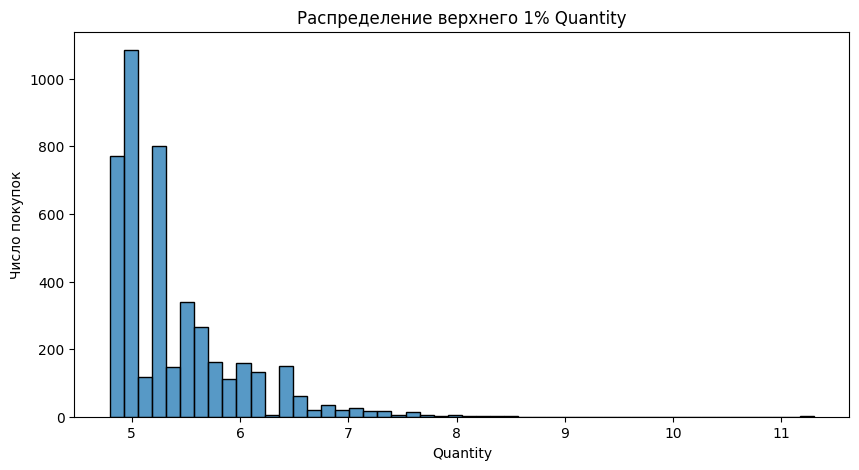

In [18]:
quantity_quantile_99_distribution = df_cleaned['Quantity'][df_cleaned['Quantity'] >= quantity_quantile_99]
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(quantity_quantile_99_distribution), bins=50)
plt.title('Распределение верхнего 1% Quantity')
plt.ylabel('Число покупок')
plt.show()

Видно, что у нас островок после 11. Попробую всё же посмотреть распределние после границы в 402, оно яснее покажет наибольшие по количеству товаров транзакции.

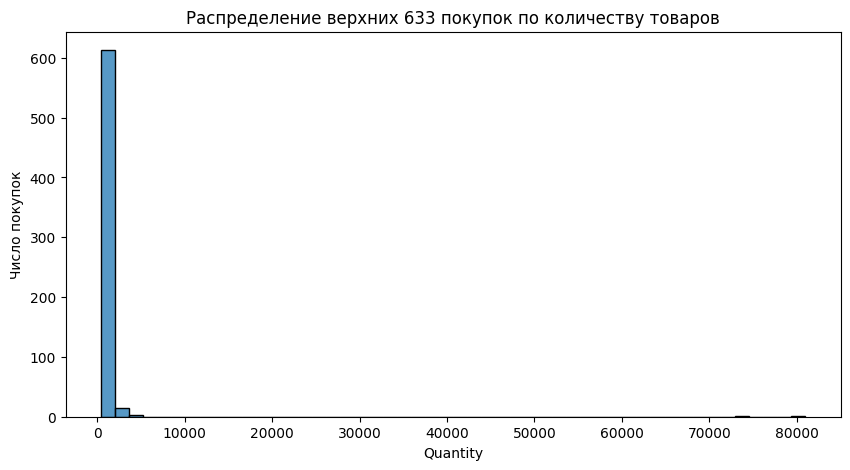

In [19]:
quantity_border_distribution = df_cleaned['Quantity'][df_cleaned['Quantity'] >= quantity_border]
plt.figure(figsize=(10, 5))
sns.histplot(quantity_border_distribution, bins=50)
plt.title('Распределение верхних 633 покупок по количеству товаров')
plt.ylabel('Число покупок')
plt.show()

Теперь ещё яснее, что у нас есть аномалии. На распределении видно, что у нас только 2 островка, где число больше 70000, но всё же я посмотрю сколько покупок, где товаров более 10000, чтобы исключить наличие единичных закупок в промежутках, а потом если пойму что таких много, то ещё отдельно посмотрю на те, где больше 70000.

In [20]:
df_cleaned[df_cleaned['Quantity'] >= 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6,2011-01
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6,2011-05


Видно, что тут именно 2 аномалии, которые стоят особняком от остальных транзакций. Я всё же их удалю, потому что они будут препятствовать анализу данных остальных тысяч клиентов и сотен тысяч транзакций. Но перед удалением операций еще посмотрю на самих людей, которые сделали эти 2 операции и пойму, это именно эти люди аномальные или именно их 2 транзакции.

In [21]:
df_cleaned[df_cleaned['CustomerID'].isin([12346.0, 16446.0])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60,2011-01
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65,2011-05
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25,2011-05
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60,2011-05


Получается это именно аномальные транзакции, а не клиенты. Удалим транзакции

In [22]:
df_cleaned = df_cleaned[~df_cleaned['Quantity'].isin([74215, 80995])]

Посмотрим, как изменилась статистика.

In [23]:
df_cleaned[['Quantity', 'UnitPrice', 'TotalAmount']].describe()

,Quantity,UnitPrice,TotalAmount
count,392690.000000,392690.000000,392690.00000
mean,12.724521,3.125922,22.00605
std,43.083646,22.241892,96.77061
min,1.000000,0.001000,0.00100
25%,2.000000,1.250000,4.95000
50%,6.000000,1.950000,12.45000
75%,12.000000,3.750000,19.80000
max,4800.000000,8142.750000,38970.00000


Да, видны изменения особенно в плане стандартного отклонения и максимумов. Также немного изменилось среднее.
Дальше рассмотрим распределение у UnitPrice.

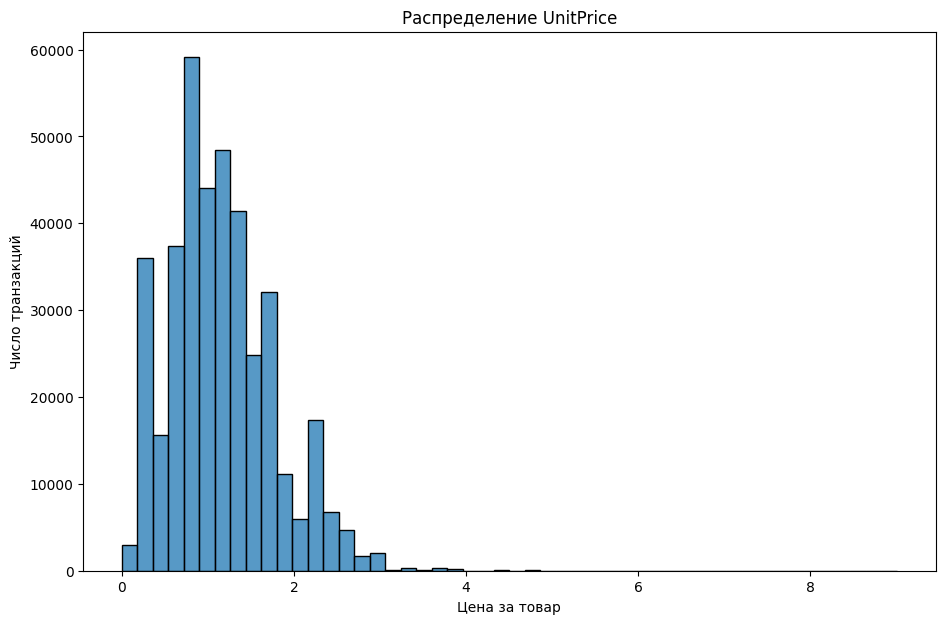

In [24]:
plt.figure(figsize=(11, 7))
sns.histplot(np.log1p(df_cleaned['UnitPrice']), bins=50)
plt.title('Распределение UnitPrice')
plt.xlabel('Цена за товар')
plt.ylabel('Число транзакций')
plt.show()

Видно, что у нас большая часть распределена примерно до 3, а подавляющее большинство до 4. Посмотрим, сколько у нас значений больше 3 и 4. Но перед этим еще поймем, какая цена скрывается за 3 и 4, потому что мы применили np.log1p, чтобы лучше посмотреть на распределение.

In [25]:
original_price_3 = np.round(np.expm1(3))
original_price_4 = np.round(np.expm1(4))
print(f'Оригинальная цена вместо 3: {original_price_3}',
      f'Оригинальная цена вместо 4: {original_price_4}', sep='\n')

Оригинальная цена вместо 3: 19.0
Оригинальная цена вместо 4: 54.0


Посмотрим, сколько у нас значений больше 3 и 4. Также посмотрим на 99-й процентиль и узнаем сколько значений больше.

In [26]:
values_greater_19 = df_cleaned['UnitPrice'][df_cleaned['UnitPrice'] >= original_price_3]
values_greater_54 = df_cleaned['UnitPrice'][df_cleaned['UnitPrice'] >= original_price_4]
unit_price_quantile_99 = df_cleaned['UnitPrice'].quantile(0.99)
values_greater_quantile_99 = df_cleaned['UnitPrice'][df_cleaned['UnitPrice'] >= unit_price_quantile_99]
count_values_greater_19 = values_greater_19.count()
count_values_greater_54 = values_greater_54.count()
count_values_greater_quantile_99 = values_greater_quantile_99.count()
print(f'Число операций с ценой за товар более 19: {count_values_greater_19}',
      f'Число операций с ценой за товар более 54: {count_values_greater_54}',
      f'Число операций с ценой за товар более 99 процентиля: {count_values_greater_quantile_99}',
      f'99-й процентиль : {unit_price_quantile_99}', sep='\n')

Число операций с ценой за товар более 19: 1234
Число операций с ценой за товар более 54: 240
Число операций с ценой за товар более 99 процентиля: 4788
99-й процентиль : 14.95


Нет смысла использовать тут 99-й процентиль, потому что слишкоми много значений, и возможно распределение будет не таким детальным, а также видно, что данные довольно сильно кучкуются при цене за товар менее 19. Для начала посмотрим распределение при цене за товар более 19, чтобы посмотреть более глобально на транзакции с большой ценой за товар, но не перегнуть с масштабом, как если бы брали 99-й процентиль.

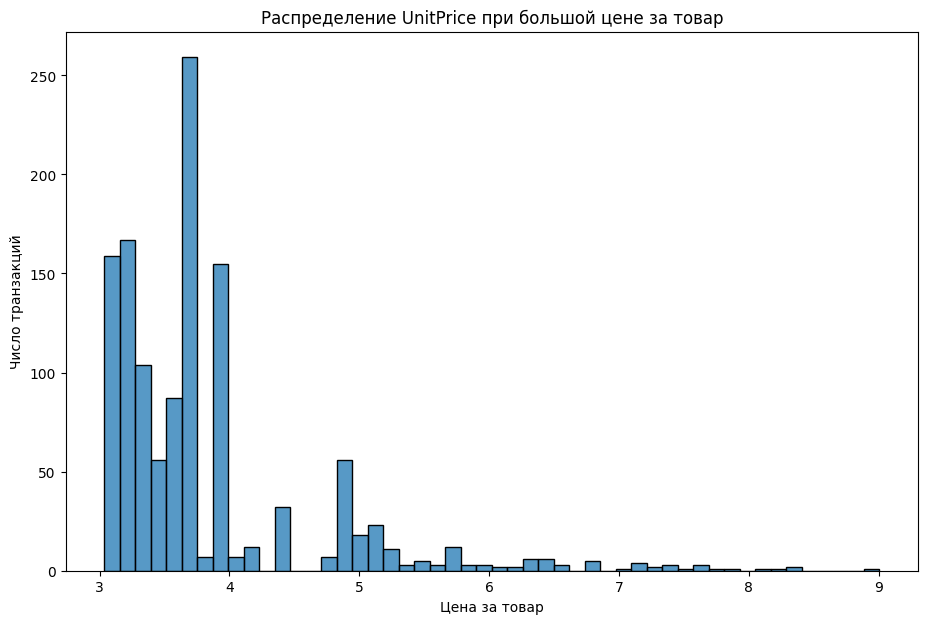

In [27]:
plt.figure(figsize=(11, 7))
sns.histplot(np.log1p(values_greater_19), bins=50)
plt.title('Распределение UnitPrice при большой цене за товар')
plt.xlabel('Цена за товар')
plt.ylabel('Число транзакций')
plt.show()

Видно, что у нас всё более менее стабильно примерно до 8. Дальше островки или просто небольшое количество . Хочется подробнее посмотреть на такие транзакции.

In [28]:
df_cleaned[df_cleaned['UnitPrice'] >= np.expm1(8)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75,2010-12
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom,3155.95,2010-12
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore,3949.32,2011-01
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France,4161.06,2011-10
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France,4161.06,2011-10


Похоже на то, что тут есть аномальные значения, особенно самое первое значение. Посмотрим подробнее на первое значение в этом срезе.
Но меня больше напрягает то, что в колонке Description надписи не похожи на товары. Если в самом начале EDA, когда я выводил head(), там были надписи похожие на товары, то сейчас нет. Я считаю, что это важно обработать, потому что мы анализируем именно покупки клиентов и их поведение, а не почтовые расходы или manual. Эти данные точно влияют на retention rate и явно не в лучшую сторону, потому что в них есть дата. С учётом этого у нас будет искажение. С одной стороны можно просто удалить все строки со станным значениями в desciption и таким образом исправить ситуацию с retention, но тогда у нас страдают показатели, связанные с прибыльи и деньгами, ведь клиент всё же и за то, что не является товаром, платит.
Думаю, что лучше всего будет создать отдельную колонку, с помощью которой будет проще фильтравать случаи, когда нужно посчитать вещи, связанные со временем, количеством покупок и активностью и фильтровать случаи, когда важно сколько денег потратили. Такой подход даст максимальную гибкость.
Но теперь перед мной встаёт другая проблема. Как найти все типы транзакций, которые не являются покупкой товара? Если есть POSTAGE, Manual, то почему не могут быть ещё подобные виды транзакций?
Но всё же для начала посмотрим на поведение покупателя с CustomerID равным 16029, чтобы понять это аномалия или нет.

In [29]:
df_cleaned[df_cleaned['CustomerID'] == 16029]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth
175,536386,84880,WHITE WIRE EGG HOLDER,36,2010-12-01 09:57:00,4.95,16029.0,United Kingdom,178.20,2010-12
176,536386,85099C,JUMBO BAG BAROQUE BLACK WHITE,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom,165.00,2010-12
177,536386,85099B,JUMBO BAG RED RETROSPOT,100,2010-12-01 09:57:00,1.65,16029.0,United Kingdom,165.00,2010-12
178,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029.0,United Kingdom,733.44,2010-12
179,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029.0,United Kingdom,647.04,2010-12
...,...,...,...,...,...,...,...,...,...,...
431946,573774,22666,RECIPE BOX PANTRY YELLOW DESIGN,36,2011-11-01 10:27:00,2.55,16029.0,United Kingdom,91.80,2010-12
431947,573774,23206,LUNCH BAG APPLE DESIGN,50,2011-11-01 10:27:00,1.45,16029.0,United Kingdom,72.50,2010-12
431948,573774,22961,JAM MAKING SET PRINTED,96,2011-11-01 10:27:00,1.25,16029.0,United Kingdom,120.00,2010-12
431949,573774,21931,JUMBO STORAGE BAG SUKI,100,2011-11-01 10:27:00,1.74,16029.0,United Kingdom,174.00,2010-12


Интересная ситуация. У него много покупок и с учетом того, что у него было в description POSTAGE, то можно преположить, что это оплата за все его многочисленные покупка.
Ещё возвращаясь к вопросам в прошлой текстовой ячейке, я заметил отличия в StockCode. Когда у нас были Manual и POSTAGE, то там были просто буквы, а тут, когда он покупал именно товары, видно, что в StockCode или просто цифры или буквы и цифры. Можно попробовать именно так отфильтровать. Но для начала нужно убедиться, что я не ошибся. Для этого посмотрю на всевозможные уникальные значения, когда StockCode состоит из букв.

In [30]:
df_cleaned[df_cleaned['StockCode'].str.isalpha()][['StockCode', 'Description']].drop_duplicates()

,StockCode,Description
45,POST,POSTAGE
2239,M,Manual
157195,PADS,PADS TO MATCH ALL CUSHIONS
317507,DOT,DOTCOM POSTAGE


Видимо, моя теория ошибочна, хотя я и нашёл ещё одну операцию DOTCOM POSTAGE, но PADS TO MATCH ALL CUSHIONS явно товар.

Посмотрим сколько у нас всего уникальных StockCode, чтобы снова понять масштаб бедствия.

In [31]:
uniq_stockcode = df_cleaned['StockCode'].nunique()
print(f'Уникальные StockCode: {uniq_stockcode}')

Уникальные StockCode: 3664


Это печально. Хотя я и выявил 3 значения, которые явно не попадают под категорию товара, но среди такого огромного количества уникальных значений могут быть ещё значения, которые не соответствуют именно операциям с товарами. Нужно постараться найти максимум таких значений. В ручную делать это глупо из-за объёма данных. Попробуем найти ещё подозрительные значения с помощью поиска по ключевым словам и просмотра уже отфильтрованных данных.

In [32]:
search_keywords = ['postage', 'manual', 'write off', 'shipping', 'delivery', 'carriage', 'freight', 'adjustment',
                   'handling', 'credit', 'refund', 'discount', 'voucher', 'dotcom']
mask_with_search_keywords = df_cleaned['Description'].str.lower().str.contains('|'.join(search_keywords))
df_cleaned[mask_with_search_keywords][['StockCode', 'Description']].drop_duplicates()

,StockCode,Description
45,POST,POSTAGE
1423,C2,CARRIAGE
2239,M,Manual
94777,22351,DOTCOMGIFTSHOP TEA TOWEL
191480,23099,FRENCH CARRIAGE LANTERN
205748,23444,Next Day Carriage
232492,85168B,BLACK BAROQUE CARRIAGE CLOCK
317507,DOT,DOTCOM POSTAGE


Перед нами скорее всего 5 операций: POSTAGE, CARRIAGE, Manual, Next Day Carriage, DOTCOM POSTAGE. Создадим отдельный столбец, в котором мы разделим товары от операций для большей гибкости и избежания искажений при дальнейшем анализе.

In [33]:
operations_stock_code = ['POST', 'C2', 'M', '23444', 'DOT']
df_cleaned['IsProduct'] = ~df_cleaned['StockCode'].isin(operations_stock_code)

В таком случае, нам нужно переопределить столбец с FirstPurchaseMonth, потому что у нас когорта может определиться по операции, что негативно повлияет на дальнейший анализ. Скорее всего, операции идут в связке с транзакциями с продуктами, так что всё будет хорошо именно с FirstPurchaseMonth глобально, но локально и в дальнейшем будем мешать в том же retention. При этом ещё нужно будет посмотреть, что нет клиентов чисто с операциями. Если есть, то удалим.

In [34]:
correct_first_purchase_month = df_cleaned[df_cleaned['IsProduct']].groupby('CustomerID')['InvoiceDate'].min()
correct_first_purchase_month = correct_first_purchase_month.dt.to_period('M')
df_cleaned['FirstPurchaseMonth'] = df_cleaned['CustomerID'].map(correct_first_purchase_month)
df_cleaned = df_cleaned[~df_cleaned['FirstPurchaseMonth'].isna()]

Посмотрим на первые строки, чтобы убедиться, что всё корректно добавлено.

In [35]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth,IsProduct
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,True
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,True
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True


Теперь посмотрим как соотносятся транзакции с товарами и транзакции с операциями, чтобы понять насколько их много от общего числа.

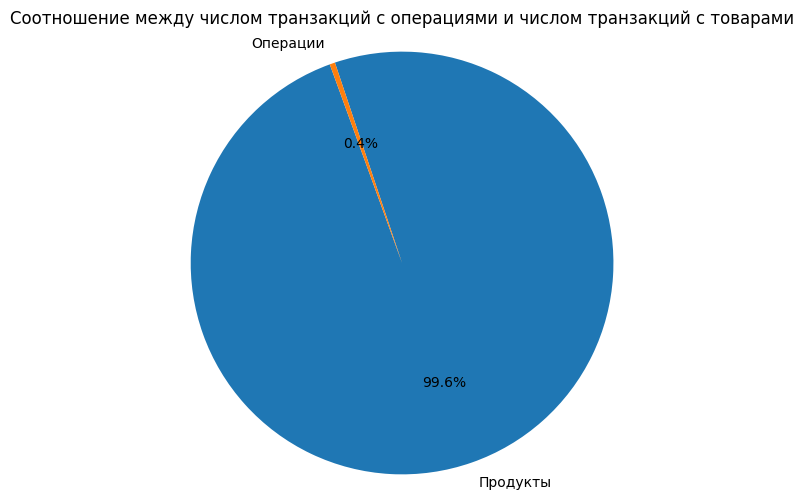

In [36]:
types_of_transactions = df_cleaned['IsProduct'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(types_of_transactions, labels=['Продукты', 'Операции'], autopct='%1.1f%%', startangle=110)
plt.title('Соотношение между числом транзакций с операциями и числом транзакций с товарами')
plt.axis('equal')
plt.show()

Подавляющее большинство транзакций связаны именно с продуктами, теперь, учитывая то огромные значения в UnitPrice, которые я нашёл и которые связаны с операциями, интересно посмотреть, а какова доля дохода, которая получена от них. Визуализируем это для наглядности.

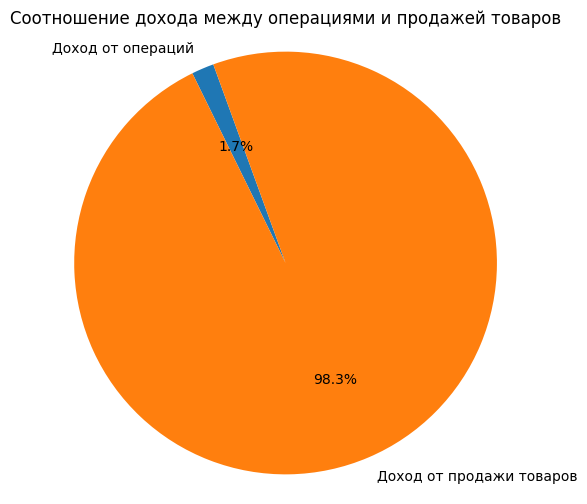

In [37]:
sum_for_products_and_operations = df_cleaned.groupby('IsProduct')['TotalAmount'].sum()
plt.figure(figsize=(6, 6))
plt.pie(sum_for_products_and_operations, labels=['Доход от операций', 'Доход от продажи товаров'], autopct='%1.1f%%', startangle=110)
plt.title('Соотношение дохода между операциями и продажей товаров')
plt.axis('equal')
plt.show()

Интересно, что процент в общем доходе в разы больше чем процент от общего числа транзакций.

Посмотрим, каких операций больше всего.

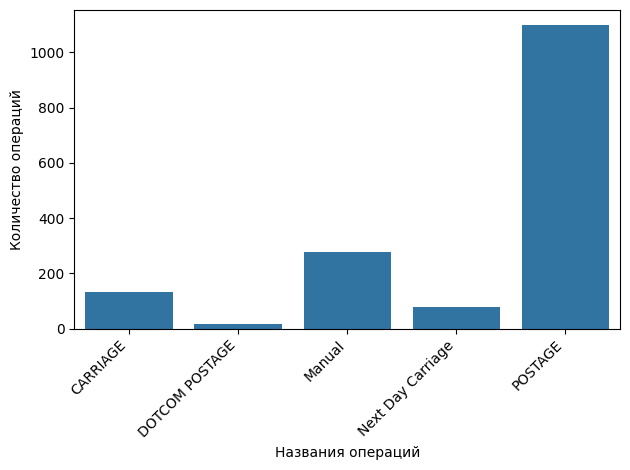

In [38]:
grouped_operations = df_cleaned[df_cleaned['IsProduct'] == False].groupby('Description')
number_of_operations = grouped_operations['Description'].count().reset_index(name='Количество операций')
number_of_operations.columns = ['Названия операций', 'Количество операций']
sns.barplot(data=number_of_operations, x='Названия операций', y='Количество операций')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Посмотрим, какие виды операций приносят больший доход.

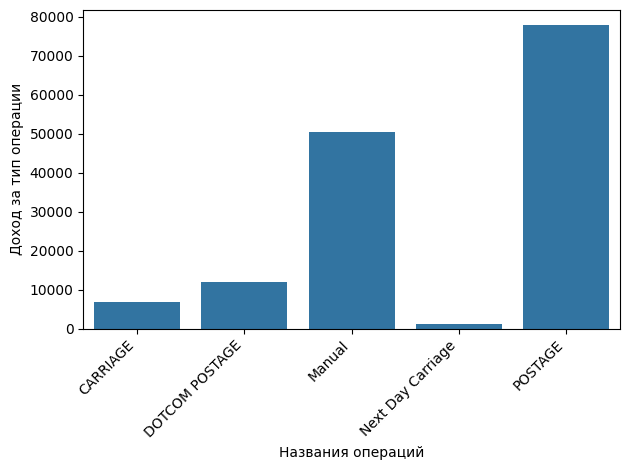

In [39]:
profit_per_operation = grouped_operations['TotalAmount'].sum().reset_index(name='Доход за тип операций')
profit_per_operation.columns = ['Названия операций', 'Доход за тип операции']
sns.barplot(profit_per_operation, x='Названия операций', y='Доход за тип операции')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Операции явно вносят не очень существенный вклад в общую массу. Поэтому стоит перейти к следующему шагу и рассмотреть TotalAmount. Начнём с того, что посмотрим распределение величин, чтобы лучше понять с чем мы работаем и, возможно, найти аномалии.

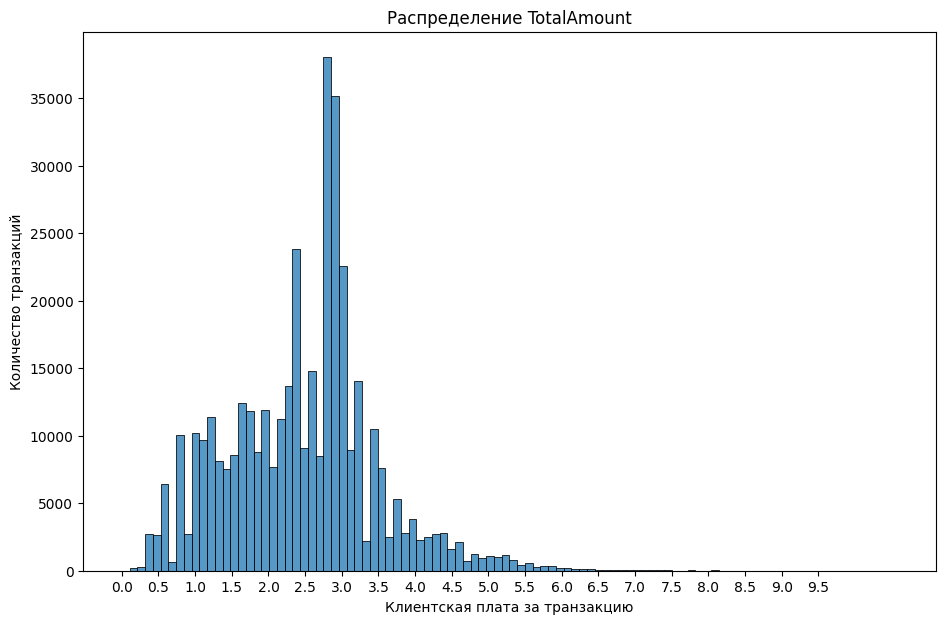

In [40]:
plt.figure(figsize=(11, 7))
sns.histplot(np.log1p(df_cleaned['TotalAmount']), bins=100)
plt.title('Распределение TotalAmount')
plt.xlabel('Клиентская плата за транзакцию')
plt.ylabel('Количество транзакций')
plt.xticks(ticks=[i * 0.5 for i in range(20)])
plt.show()

Видно, что основаня масса платы клиентов за транзакцию находится примерно до 7,5. Есть 2 островка, где клиент платил более 7,5, будет интересно посмотреть на эти островки.

In [41]:
df_cleaned[np.log1p(df_cleaned['TotalAmount']) > 8]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth,IsProduct
16438,537659,21623,VINTAGE UNION JACK MEMOBOARD,600,2010-12-07 16:43:00,6.38,18102.0,United Kingdom,3828.00,2010-12,True
19871,537899,22328,ROUND SNACK BOXES SET OF 4 FRUITS,1488,2010-12-09 10:44:00,2.55,12755.0,Japan,3794.40,2010-12,True
52132,540689,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1010,2011-01-11 08:43:00,3.24,17450.0,United Kingdom,3272.40,2010-12,True
52134,540689,22470,HEART OF WICKER LARGE,1284,2011-01-11 08:43:00,3.21,17450.0,United Kingdom,4121.64,2010-12,True
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55,15749.0,United Kingdom,4921.50,2011-01,True
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2011-01-11 12:55:00,1.85,15749.0,United Kingdom,3700.00,2011-01,True
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,6539.40,2011-01,True
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.55,15749.0,United Kingdom,3315.00,2011-01,True
52772,540818,48185,DOORMAT FAIRY CAKE,670,2011-01-11 12:57:00,6.75,15749.0,United Kingdom,4522.50,2011-01,True
84319,543378,21623,VINTAGE UNION JACK MEMOBOARD,504,2011-02-07 15:34:00,6.38,18102.0,United Kingdom,3215.52,2010-12,True


Даже с учётом того, что я сдвинул нижнюю границу к 8, не видно никаких аномалий.

Интересно посмотреть как меняется доход от месяца к месяцу. Может быть, есть какие-то тенденции, может быть в какие-то месяцы есть резкий рост, а потом спад, такое могло бы быть, допустим, в декабре или январе из-за праздников. Посмотрим сразу на то, как меняется общий доход, доход от продажи товаров и доход от операций.

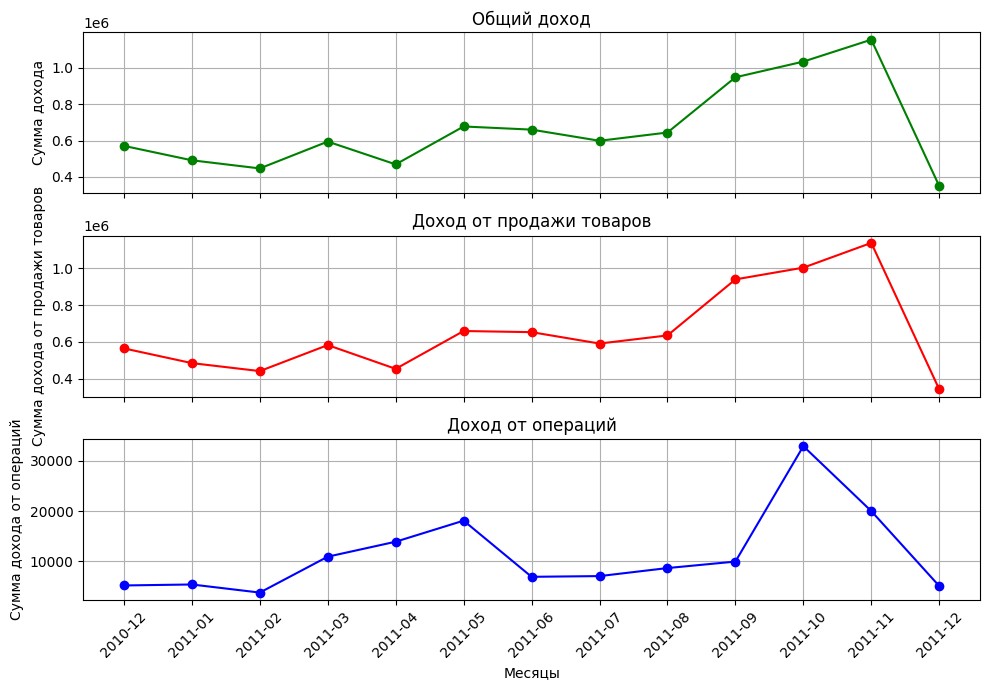

In [42]:
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.to_period('M')
total_income = df_cleaned.groupby('Month')['TotalAmount'].sum()
operations_income = df_cleaned[~df_cleaned['IsProduct']].groupby('Month')['TotalAmount'].sum()
product_income = df_cleaned[df_cleaned['IsProduct']].groupby('Month')['TotalAmount'].sum()
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
axes[0].plot(total_income.index.astype(str), total_income, marker='o', color='green')
axes[0].set_title('Общий доход')
axes[0].set_ylabel('Сумма дохода')
axes[1].plot(product_income.index.astype(str), product_income, marker='o', color='red')
axes[1].set_title('Доход от продажи товаров')
axes[1].set_ylabel('Сумма дохода от продажи товаров')
axes[2].plot(operations_income.index.astype(str), operations_income, marker='o', color='blue')
axes[2].set_title('Доход от операций')
axes[2].set_ylabel('Сумма дохода от операций')
axes[2].set_xlabel('Месяцы')
for axis in axes:
    axis.grid(True)
    axis.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Ожидаемо, что общий доход и доход от продажи товаров практически друг друга повторяют с учётом того, что доход от продажи товаров это 98,3% от общей выручки. Наверное, в контексте этого нужно расставить приоритеты и сосредоточиться именно на общей массе покупок или покупке товаров, потому что доля операций ничтожна. Интересно, что зимой доход наименьший. Особенно интересно, что у нас нет резкого скачка роста в декабре-январе из-за подарков к новому году. Возможно, это обусловленно тем, что у нас в декабре, что начало, что конец промежутка наблюдения и нет полной информации за месяц. В марте у нас всплеск, возможно, из-за 8 марта. Нужно будет подробно посмотреть распределение в марте, если там будет всплеск покупок до 8-10 марта, то скорее всего это люди заготавливают подарки или докупают их, если забыли вовремя это сделать. Также нужно обратить внимание на конец марта, потому что в 2011 году 3 апреля праздновали день матери, и люди могли готовиться к нему. Всё это может объяснить то, что март выделяется на фоне других весенних месяцев. Летом заметна явная стагнация и рост только к августу, возможно, из-за подготовки к школе. Осенью люди покупают больше всего, возможно, из-за большого количества праздников по типу чёрной пятницы, ночи костров, хэллоуин и тд.

Посмотрим границы от какого времени и до какого у нас вообще информация.

In [43]:
min_date = df_cleaned['InvoiceDate'].min()
max_date = df_cleaned['InvoiceDate'].max()
print(f'Минимальная дата: {min_date}' + '\n' +  f'Максимальная дата: {max_date}')

Минимальная дата: 2010-12-01 08:26:00
Максимальная дата: 2011-12-09 12:50:00


Это частично объясняет, почему в конце нашего промежута наблюдение в декабре 2011 года такой небольшой доход, у нас не успела пройти и половина декабря, самые денежные моменты ещё не наступили. Получается, учитывая это, возможно, можно сказать, что у нас есть долгосрочный тренд на рост дохода, нужно будет посмотреть потом посмотреть чем это обусловленно, временем жизни клиентов и их постепенным накоплением или взрывным ростом новых клиентов, но без сильного накопления их числа. Кроме того, интересно отметить, что декабрь 2010 года даже не в топ-6, что очень странно с учетом того, что у нас данные с первого декабря. Ещё стоит отметить, что последняя месячная когорта из-за этого не слишком репрезентативна и стоит быть осторожным с её анализом.

Посмотрим более подробно на нескоторые аномальные месяцы. Посмотрим на декабрь 2010 года, март 2011 года и осень 2011 года.

Для начала добавим колонку с днями, потом напишем функцию, которая будет строить графики для различных месяцев. На основании графиков поймем, как сильно праздники влияют на прибыль. Потом, собственно, посмотрим на месяцы.

In [44]:
df_cleaned['PurchaseDay'] = df_cleaned['InvoiceDate'].dt.to_period('D')
def monthly_charts_and_top_days(df, month_name, month):
    df_month = df[df['Month'] == month].groupby('PurchaseDay')['TotalAmount'].sum()
    plt.figure(figsize=(10, 5))
    plt.plot(df_month.index.astype(str), df_month.values, marker='o', color='green')
    plt.title(f'Доход за {month_name}')
    plt.xlabel('Дата')
    plt.ylabel('Доход')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    top_five_days = df_month.nlargest(5)
    print(f'Топ-5 дней по выручке за {month_name}')
    for date, income in top_five_days.items():
        print(f'{date}: {income}')

Посмотрим данные за декабрь 2010 года.

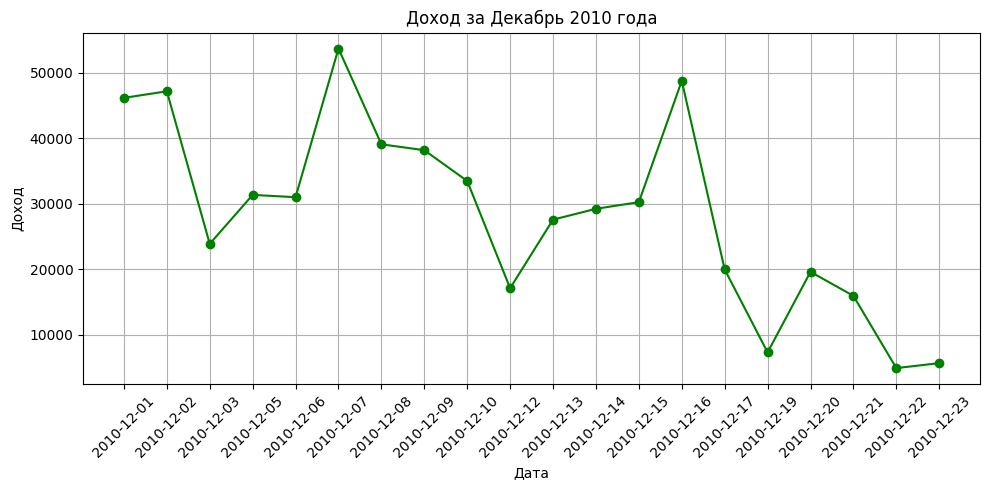

Топ-5 дней по выручке за Декабрь 2010 года
2010-12-07: 53730.96
2010-12-16: 48791.87
2010-12-02: 47197.57
2010-12-01: 46192.49
2010-12-08: 39094.2


In [45]:
monthly_charts_and_top_days(df_cleaned, 'Декабрь 2010 года', '2010-12')

Неожиданно. У нас отсутствует самый пик продаж в декабре. Это объясняет, почему такой маленький доход за декабрь 2010 года.
В связи с этим хочу посмотреть на январь, может там тоже неполные данные за месяц.

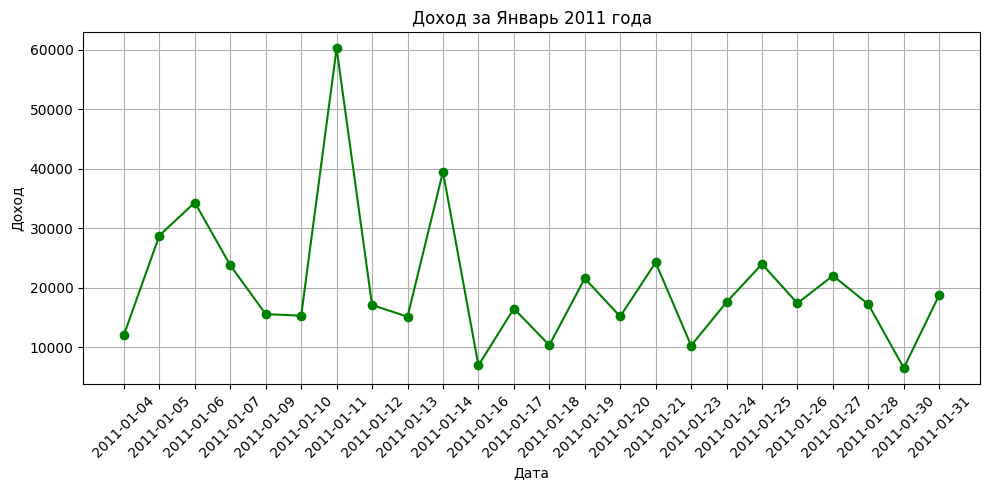

Топ-5 дней по выручке за Январь 2011 года
2011-01-11: 60243.73
2011-01-14: 39509.7
2011-01-06: 34343.79
2011-01-05: 28799.43
2011-01-21: 24276.01


In [46]:
monthly_charts_and_top_days(df_cleaned, 'Январь 2011 года', '2011-01')

Тут тоже отсутствует часть данных, самая важная за январь. Вместе с декабрем получается, что нет данных за новогодние праздники.

Теперь посмотрим на март 2011 года.

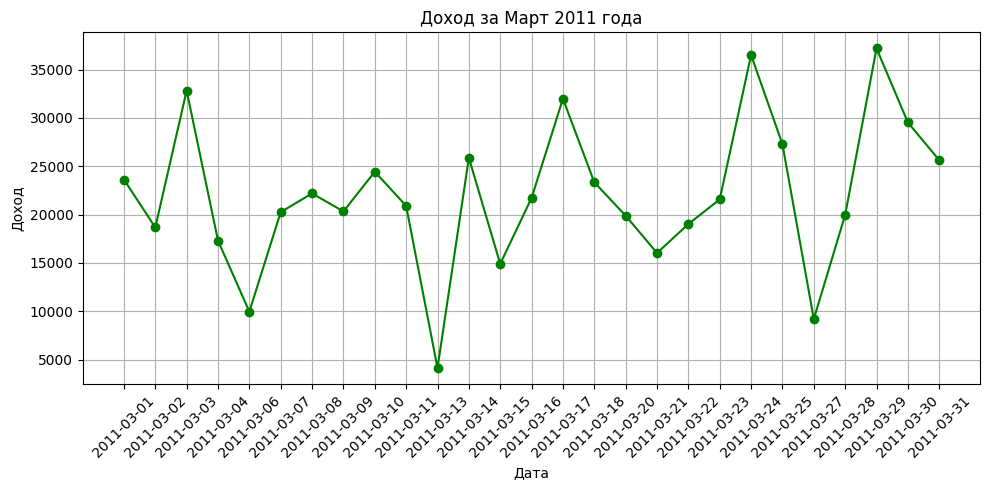

Топ-5 дней по выручке за Март 2011 года
2011-03-29: 37190.52
2011-03-24: 36496.79
2011-03-03: 32818.19
2011-03-17: 31976.51
2011-03-30: 29523.85


In [47]:
monthly_charts_and_top_days(df_cleaned, 'Март 2011 года', '2011-03')

Тут нет какого-то явного роста продаж перед праздниками по типу 8 марта или подготовки к дню матери. Получается, что аномальность этого месяца среди весенних, объясняется не этим.

Теперь посмотрим на сентябрь 2011 года.

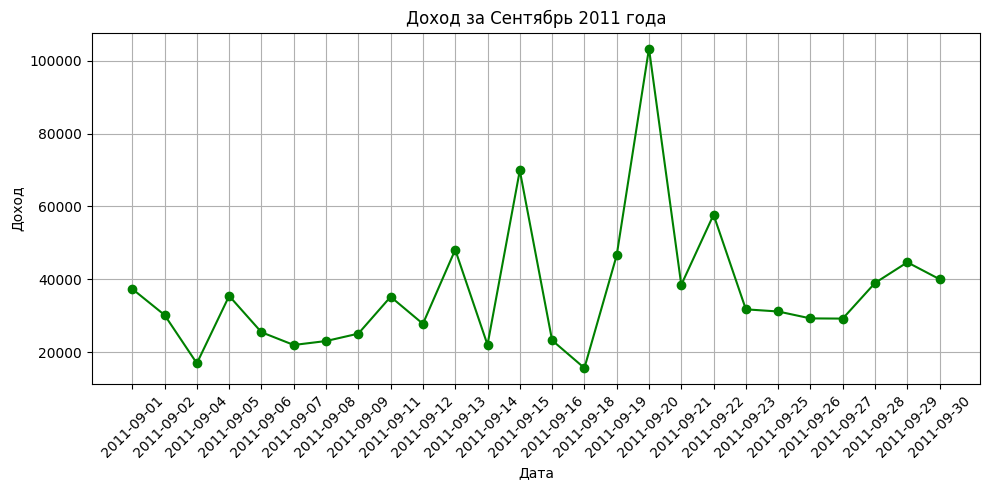

Топ-5 дней по выручке за Сентябрь 2011 года
2011-09-20: 103377.68
2011-09-15: 69893.59
2011-09-22: 57734.98
2011-09-13: 48116.5
2011-09-19: 46588.21


In [48]:
monthly_charts_and_top_days(df_cleaned, 'Сентябрь 2011 года', '2011-09')

Тут также нет никакой взаимосвязи с праздникми, хотя есть 2 пика продаж, которые выделяются на фоне остального месяца. Есть несколько дат, которые вытягивают месяц по доходу, но они не связаны с событиями сентября 2011 года. Но, возможно, это связанно с началом сезона распродаж осенью.

Теперь посмотрим на октябрь 2011 года.

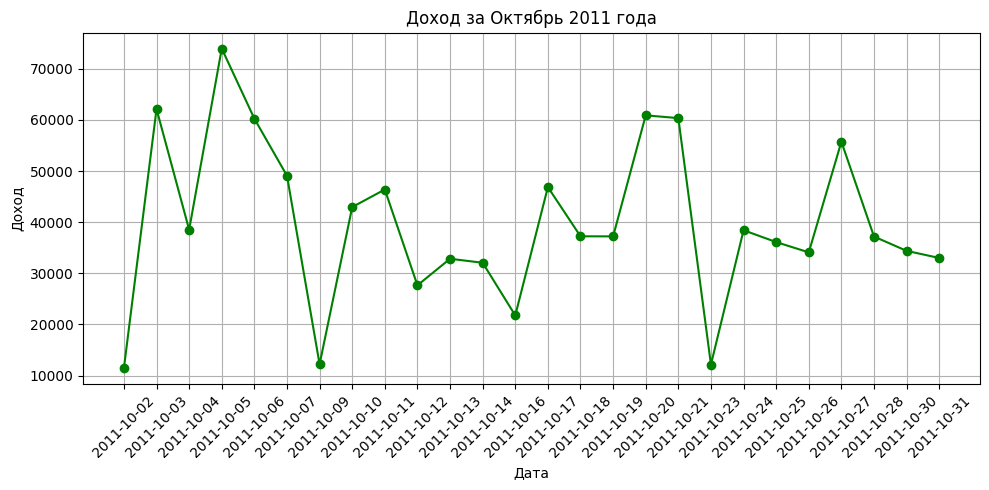

Топ-5 дней по выручке за Октябрь 2011 года
2011-10-05: 73975.56999999999
2011-10-03: 62143.07
2011-10-20: 60910.3
2011-10-21: 60364.01
2011-10-06: 60258.53


In [49]:
monthly_charts_and_top_days(df_cleaned, 'Октябрь 2011 года', '2011-10')

Тут тоже нет какой-то выраженности роста продаж к праздникам по типу хэллоуина. Нет какой-то выраженной тенденции.

Теперь посмотрим на ноябрь 2011.

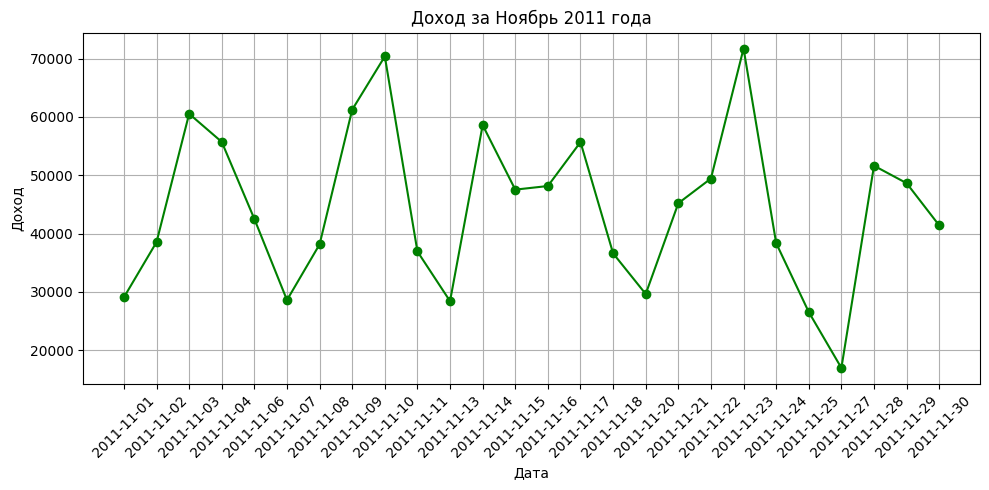

Топ-5 дней по выручке за Ноябрь 2011 года
2011-11-23: 71722.75
2011-11-10: 70373.03
2011-11-09: 61241.58
2011-11-03: 60536.090000000004
2011-11-14: 58595.22


In [50]:
monthly_charts_and_top_days(df_cleaned, 'Ноябрь 2011 года', '2011-11')

Тут данные по продажам также скачут, и нет чёткой тенденции. Некоторые важные даты пропущены. По типу ночи костров 5 ноября, что может портить картину по доходам. Акция, связанная с чёрной пятницой 25 ноября, видимо, не принесла много прибыли, если такая акция вообще была.

В общем, видно, что магазин не очень хорошо зарабатывает на праздниках, хотя можно было бы ожидать обратного. Возможно, стоит улучшить маркетинг, добавить акции и скидки, приуроченные к важным датам, и добавить побольше товаров, возможно, сезонных.
Также видно, что некоторые праздничные дни или праздники просто отсутствуют в той версии датасета, что есть у меня. Это говорит об одном из двух: или у нас изначально не было информации по этим датам, что ужасно, потому что тогда бизнес теряет значительные суммы денег, или данные были плохого качества для когортного анализа, поэтому их пришлось удалить, но в таком случае, как бизнес мог допустить, чтобы в эти важные даты нормально не заносилась информация о покупках.

Теперь посмотрим на то, как клиенты распределены между странами.
Для начала поймем, как соотносятся доходы от UK и остальных стран, насколько вообще доход от других стран существенен в общей картине.

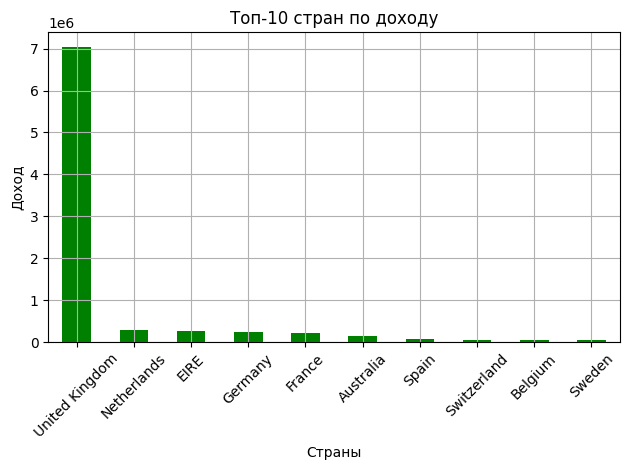

In [51]:
top_countries = df_cleaned.groupby('Country')['TotalAmount'].sum().nlargest(10)
top_countries.plot(kind='bar', color='green')
plt.title('Топ-10 стран по доходу')
plt.xlabel('Страны')
plt.ylabel('Доход')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

UK с огромным отрывом обгоняет другие страны. Но всё же интересно, какой процент вообще от общей массы дохода составляют UK и другие страны, потому что хотя и UK превосходит конкурентов, но вместе взятые другие страны могут суммарно дать сопоставимый доход.

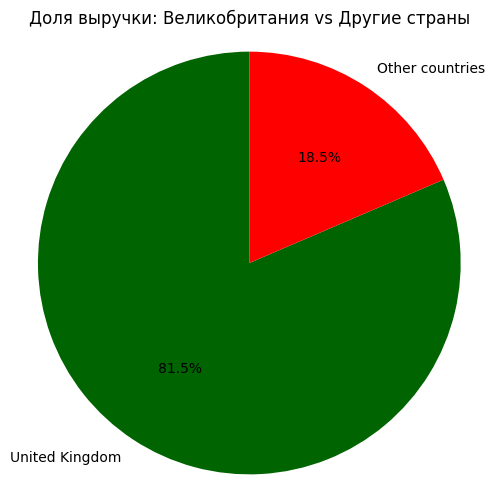

In [52]:
income_by_country = df_cleaned.groupby('Country')['TotalAmount'].sum()
uk_income = income_by_country['United Kingdom']
non_uk_income = income_by_country[income_by_country.index != 'United Kingdom'].sum()
comparison = pd.Series({'United Kingdom': uk_income,
              'Other countries': non_uk_income})
plt.figure(figsize=(6, 6))
plt.pie(comparison, labels=comparison.index, autopct='%1.1f%%', colors=['darkgreen', 'red'], startangle=90)
plt.title('Доля выручки: Великобритания vs Другие страны')
plt.axis('equal')
plt.show()

Неожиданно высокая доля Non-UK клиентов для магазина из UK. В когортном анализе нужно будет учитывать это. Возможно, можно будет найти какие-нибудь инсайды или значимые отличия от UK клиентов. 
Поэтому добавим ещё один столбец, где будет указано клиент из UK или non-UK.

In [53]:
df_cleaned['Region'] = df_cleaned['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'Non-UK')
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,FirstPurchaseMonth,IsProduct,Month,PurchaseDay,Region
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,True,2010-12,2010-12-01,UK
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True,2010-12,2010-12-01,UK
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,True,2010-12,2010-12-01,UK
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True,2010-12,2010-12-01,UK
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,True,2010-12,2010-12-01,UK


Теперь сравним колчество транзакий в UK и Non-UK

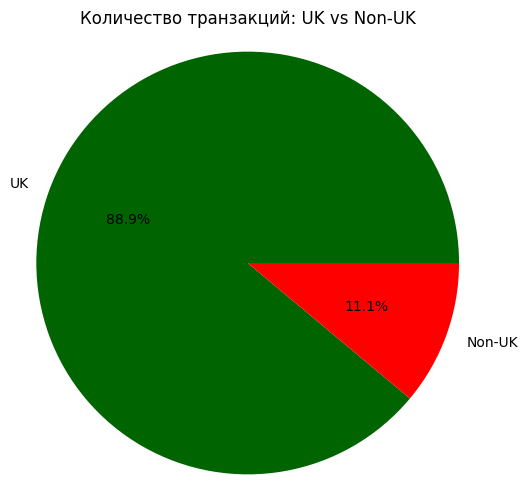

In [54]:
transactions_per_region = df_cleaned['Region'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(transactions_per_region, labels=transactions_per_region.index, autopct='%1.1f%%', colors=['darkgreen', 'red'])
plt.title('Количество транзакций: UK vs Non-UK')
plt.axis('equal')
plt.show()

Интересно, что доля транзакций Non-UK меньше почти наполовину по сравнению с долей дохода от Non-UK, что свидетельствует о наличии относительно большого числа более крупных покупок.
Теперь будет интересно посмотреть на различие в самых продаваемых товарах в этих 2 группах. Это позволит приблизительно посмотреть на предпочтения 2 этих групп.
Посмотрим на топ-5 товаров в каждой группе по прибыли.

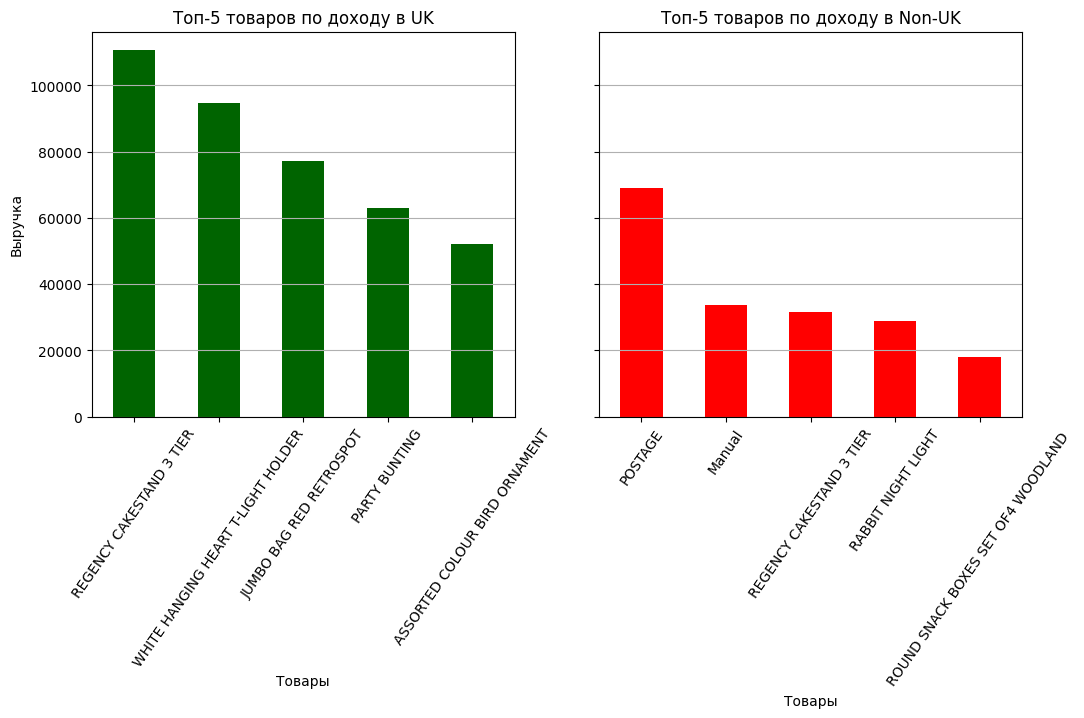

In [55]:
uk_products = df_cleaned[df_cleaned['Region'] == 'UK'].groupby('Description')['TotalAmount'].sum().nlargest(5)
non_uk_products = df_cleaned[df_cleaned['Region'] == 'Non-UK'].groupby('Description')['TotalAmount'].sum().nlargest(5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
uk_products.plot(kind='bar', ax=ax1, color='darkgreen')
ax1.set_title('Топ-5 товаров по доходу в UK')
ax1.set_xlabel('Товары')
ax1.set_ylabel('Выручка')
ax1.grid(True, axis='y')
ax1.tick_params(axis='x', rotation=55)
non_uk_products.plot(kind='bar', ax=ax2, color='red')
ax2.set_title('Топ-5 товаров по доходу в Non-UK')
ax2.set_xlabel('Товары')
ax2.grid(True, axis='y')
ax2.tick_params(axis='x', rotation=55)
plt.show()

Интересно, что у Non-UK самыми дходными являются не товары, а операции, что, может быть, обусловленно дорогой доставкой и перевозкой в другие страны.
Самый прибыльный товар в UK есть и в топе в Non-UK, там он на 3 месте. Из видов товаров, которые встречаются и там, и там можно отметить светильники, 2 и 4 места в UK и Non-UK соответсвенно, также товары, косвенно связанные с едой.
Теперь посмотрим на топ-5 по количеству заказов. Тут будем использовать фильтрацию именно по IsProduct, потому что это гипотетически косвенно связано с удержанием и привлечением, так что лучше именно товары смотеть.

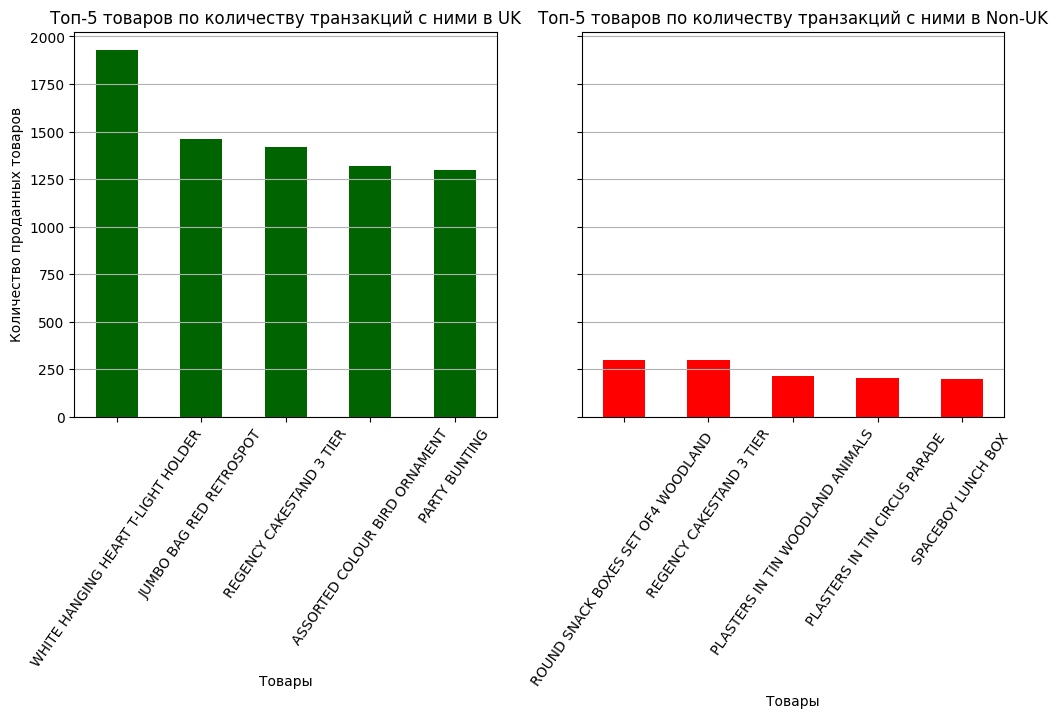

In [56]:
uk_freq = df_cleaned[(df_cleaned['Region'] == 'UK') & (df_cleaned['IsProduct'])].groupby('Description')['Description'].count().nlargest(5)
non_uk_freq = df_cleaned[(df_cleaned['Region'] == 'Non-UK') & (df_cleaned['IsProduct'])].groupby('Description')['Description'].count().nlargest(5)
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
uk_freq.plot(kind='bar', ax=ax3, color='darkgreen')
ax3.set_title('Топ-5 товаров по количеству транзакций с ними в UK')
ax3.set_xlabel('Товары')
ax3.set_ylabel('Количество проданных товаров')
ax3.grid(True, axis='y')
ax3.tick_params(axis='x', rotation=55)
non_uk_freq.plot(kind='bar', ax=ax4, color='red')
ax4.set_title('Топ-5 товаров по количеству транзакций с ними в Non-UK')
ax4.set_xlabel('Товары')
ax4.grid(True, axis='y')
ax4.tick_params(axis='x', rotation=55)
plt.show()

В Non-UK видно, что топ 3 и топ 4 похожи, обе из одной категории. Тут только одно пересечение это топ 3 в UK товарах и топ 2 в Non-UK товарах. Это вместе с прошлым показывает, что на самом верхнем уровне пересечение не так велико.

## Когортный анализ
Теперь после исследования в общих чертах и предобработки данных перейдём к самому когортному анализу. Его мы будем делать перекрестно, формировать когорты будем по месяцам и региону(или UK, или Non-UK). Иногда будем сравнивать когорты чисто одним способом или по месяцам, или по региону. В качестве первой оси я выбрал именно время, потому что во время EDA я также наметил некоторые странности по типу долгосрочной тенденции к росту, отстутствия всплеска в праздники, аномальные месяцы, которые может помочь прояснить анализ когорт и просмотр различных метрик. Ещё стоит уточнить, что нужно аккуратно относиться к хронологически последним месячным когортам, потому что у них меньше времени себя показать, а время всё же влияет на метрики. Я считаю, что когортная ось по месяцам может быть теоретически одна из самых простых и эффективных точек роста, поэтому планирую, что это будет основная ось анализа. Также решил добавить доболнительную ось анализа(разделение Non-UK и UK), потому что это гипотетически может найти новые точки роста, связанные с доходом от крупных покупок Non-UK клиентов или большим количеством операций или чем-то, что я, возможно, обнаружу во время когортного анализа.
Теперь определим примерно, что я буду считать и смотреть во время когортного анализа:
1. Количество уникальных пользователей по когортам
2. Доля тех, кто сделал только одну покупку VS тех, кто сделал несколько
3. Средний чек
4. Среднее время между покупками
5. Среднее количество покупок
6. ARPU
7. Return retention

В конце когортного анализа сделаю общие выводы по тому, что узнал, как и из EDA (некоторое в отрыве от когортного анализа), так и из самого когортного анализа.

Посчитаем сначала число уникальных пользователей по регионам. Нарисуем график для наглядности.

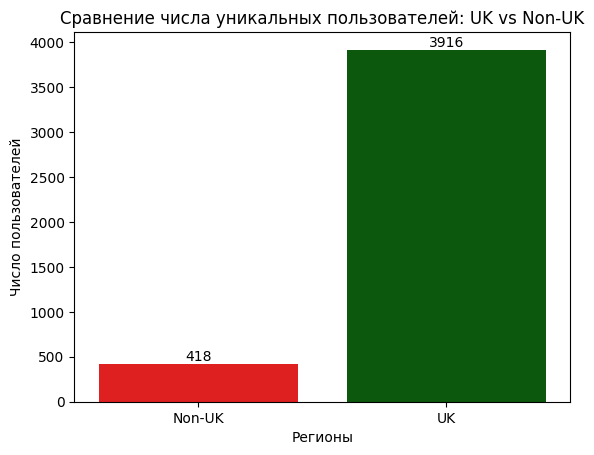

In [138]:
unique_customers_by_region = df_cleaned[['Region', 'CustomerID']].drop_duplicates().groupby('Region').count().reset_index()
unique_customers_by_region.columns = ['Регион', 'Число пользователей']
ax = sns.barplot(x='Регион', y='Число пользователей', hue='Регион', palette=['red', 'darkgreen'], data=unique_customers_by_region)
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width() / 2,
            patch.get_height() + 0.5,
            f'{int(patch.get_height())}',
                ha='center',
                va='bottom',
                fontsize=10)
plt.xlabel('Регионы')
plt.ylabel('Число пользователей')
plt.title('Сравнение числа уникальных пользователей: UK vs Non-UK')
plt.show()

Видно, что Non-UK клиентов значительно меньше, чем UK клиентов. Получается доля Non-UK клиентов примерно 9,5% от общей массы, а UK клиентов 90,5%. Но по EDA мы знаем, что проценто дохода от Non-UK составляет 18,5%. Так что они по-видимому доходнее.

Теперь посмотрим на когорты в разрезе месяцев. Сколько уникальных пользователей пришли в каждый месяц.

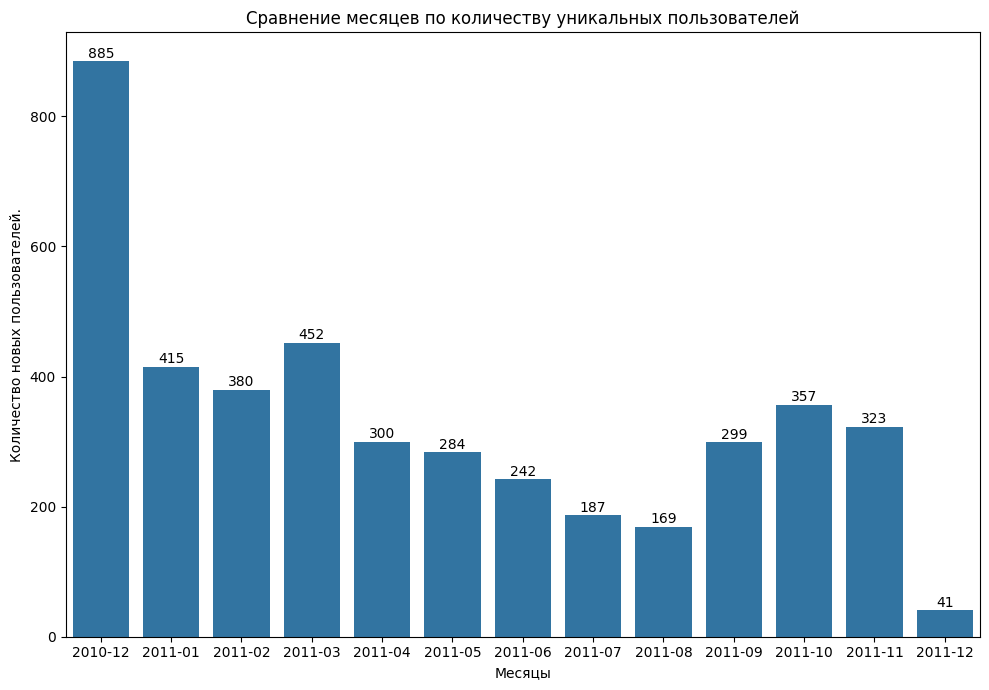

In [141]:
unique_customers_by_month = df_cleaned[['FirstPurchaseMonth', 'CustomerID']].drop_duplicates().groupby('FirstPurchaseMonth').count().reset_index()
unique_customers_by_month.columns = ['Месяц', 'Число пользователей']
plt.figure(figsize=(10, 7))
ax_cust = sns.barplot(x='Месяц', y='Число пользователей', data=unique_customers_by_month)
for patch in ax_cust.patches:
    ax_cust.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height() + 0.5,
        f'{int(patch.get_height())}',
        ha='center',
        va='bottom',
        fontsize=10)
plt.xlabel('Месяцы')
plt.ylabel('Количество новых пользователей.')
plt.title('Сравнение месяцев по количеству уникальных пользователей')
plt.tight_layout()
plt.show()

Интересно, что в декабре 2010 года так много людей пришло. С одной сторны, этого можно было бы ожидать, а с другой стороны, с учётом того, что в EDA я узнал, что в декабре 2010 года и январе 2011 нет толком нормальных продаж и нет данных по новогодним праздникам. Получается, что скорее всего вся эта масса сделала не слишкои болшие покупки, но при этом в EDA я заметил, что есть долгосрочный тренд на рост дохода. Скорее всего клиенты всё же накапливаются, потому что в противовес тому, что в ноябре 2011 пик дохода, мы видим, что там не так уж и аномально много клиентов. Из этого следует, что скорее всего там или много аномально много больших покупок, или клиенты массово начали возвращаться, или тем, что клиенты из UK или Non-UK массово закупаются, или и то, и то. Интересно также посмотреть какие когорты наиболее долгоживущие, и, когда они возвращаются.

Напишем функцию, чтобы подписывать столбцы у столбчатой диаграммы.

In [59]:
def text_for_barplot(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2,
                    height + 0.1,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=10)

Теперь посмотрим ещё сразу и в разрезе UK/Non-UK.

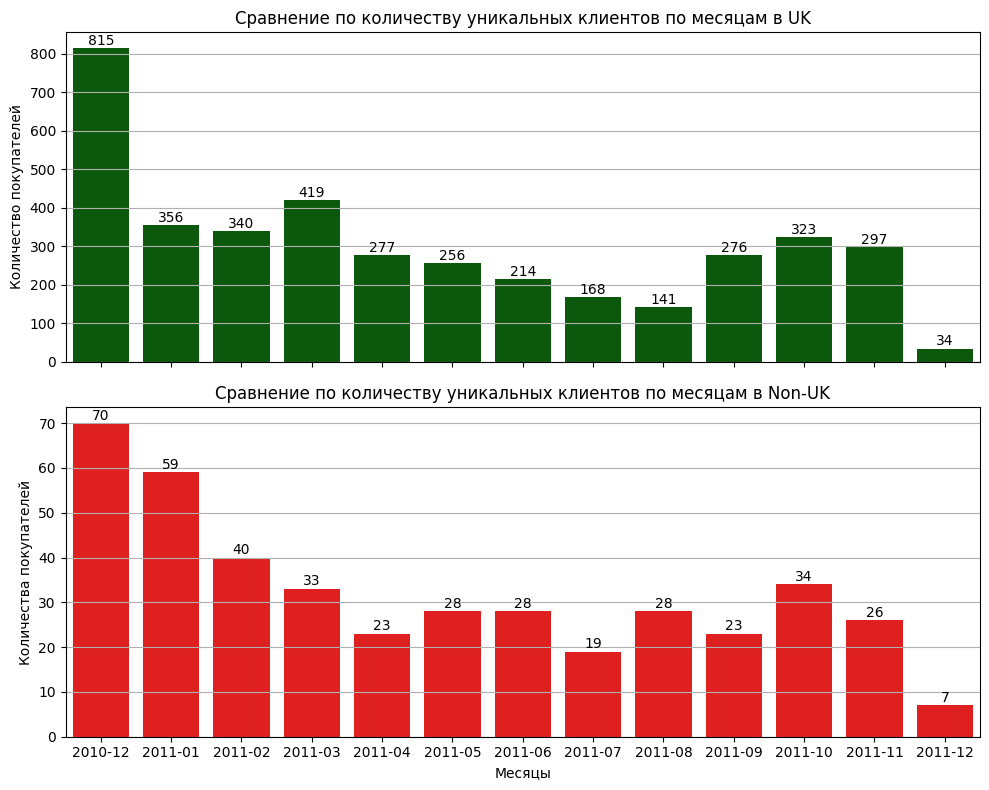

In [140]:
def region_barplot(region_name):
    unique_users_per_reg_and_month = df_cleaned[['FirstPurchaseMonth', 'CustomerID', 'Region']][df_cleaned['Region'] == region_name].drop_duplicates()[['FirstPurchaseMonth', 'Region']].groupby('FirstPurchaseMonth').count().reset_index()
    unique_users_per_reg_and_month.columns = ['Месяц', 'Число пользователей']
    return unique_users_per_reg_and_month


new_uk_customers_per_month = region_barplot('UK')
new_non_uk_customers_per_month = region_barplot('Non-UK')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
sns.barplot(x='Месяц', y='Число пользователей', data=new_uk_customers_per_month, ax=ax1, color='darkgreen')
ax1.set_title('Сравнение по количеству уникальных клиентов по месяцам в UK')
ax1.set_ylabel('Количество покупателей')
ax1.grid(True, axis='y')
text_for_barplot(ax1)
sns.barplot(x='Месяц', y='Число пользователей', data=new_non_uk_customers_per_month, ax=ax2, color='red')
ax2.set_title('Сравнение по количеству уникальных клиентов по месяцам в Non-UK')
ax2.set_ylabel('Количества покупателей')
ax2.set_xlabel('Месяцы')
ax2.grid(True, axis='y')
text_for_barplot(ax2)
plt.tight_layout()
plt.show()

Интересно, что если не брать декабрь 2010 года, январь 2011 года и декабрь 2011 года, то количество уникальных клиентов каждый месяц сильно не отклоняется. Нет никаких аномальных отклонений у Non-UK по сравнению с UK кроме, возможно, января 2011 года, но возможно тут просто просто совпадение или влияние не самого большого числа Non-UK клиентов. Ещё моя прошлая мысль про то, что, может быть, в ноябре 2011 Non-UK будут массово активничать, дала трещину. Посмотрим конечно по закупкам ещё, но там явно нет аномального привлечения.

Теперь выясним долю тех, кто сделал одну покупку и тех, кто много. Сначала в разрезе Non-UK/UK.

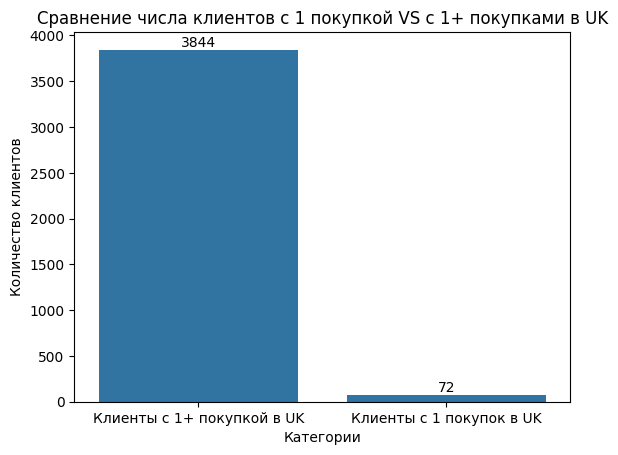

In [61]:
purchase_count = df_cleaned[df_cleaned['IsProduct']]
purchase_count = purchase_count[['CustomerID', 'FirstPurchaseMonth', 'Region']].groupby('CustomerID').size().reset_index(name='PurchaseCount')
purchase_count = purchase_count.merge(df_cleaned[['CustomerID', 'FirstPurchaseMonth', 'Region']].drop_duplicates(),
                                      on='CustomerID',
                                      how='left')
uk_purchase_count = pd.DataFrame({'Категория': ['Клиенты с 1+ покупкой в UK', 'Клиенты с 1 покупок в UK'],
                                  'Количество': [purchase_count[(purchase_count['PurchaseCount'] > 1) & (purchase_count['Region'] == 'UK')].shape[0],
                                     purchase_count[(purchase_count['PurchaseCount'] == 1) & (purchase_count['Region'] == 'UK')].shape[0]]})
ax3 = sns.barplot(x='Категория', y='Количество', data=uk_purchase_count)
text_for_barplot(ax3)
plt.xlabel('Категории')
plt.ylabel('Количество клиентов')
plt.title('Сравнение числа клиентов с 1 покупкой VS с 1+ покупками в UK')
plt.show()

Очень даже солидное число и соотношение. Получается, что подавляющее число клиентов возвращаются. Нужно только будет потом понять через сколько, как много, сколько это приносит. Но пока рано это делать. Перейдем к Non-UK и потом к когортам по месяцам, чтобы получить более полную картину.

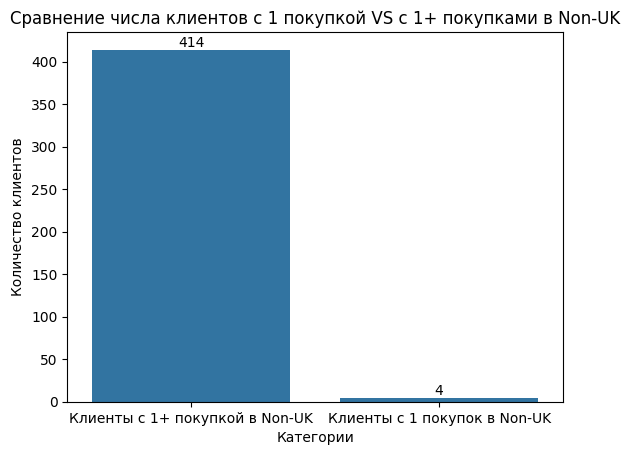

In [62]:
non_uk_purchase_count = pd.DataFrame({'Категория': ['Клиенты с 1+ покупкой в Non-UK', 'Клиенты с 1 покупок в Non-UK'],
                                  'Количество': [purchase_count[(purchase_count['PurchaseCount'] > 1) & (purchase_count['Region'] == 'Non-UK')].shape[0],
                                     purchase_count[(purchase_count['PurchaseCount'] == 1) & (purchase_count['Region'] == 'Non-UK')].shape[0]]})
ax3 = sns.barplot(x='Категория', y='Количество', data=non_uk_purchase_count)
text_for_barplot(ax3)
plt.xlabel('Категории')
plt.ylabel('Количество клиентов')
plt.title('Сравнение числа клиентов с 1 покупкой VS с 1+ покупками в Non-UK')
plt.show()

Ещё более подавляющее сотношение. Теперь по месяцам посмотрим.

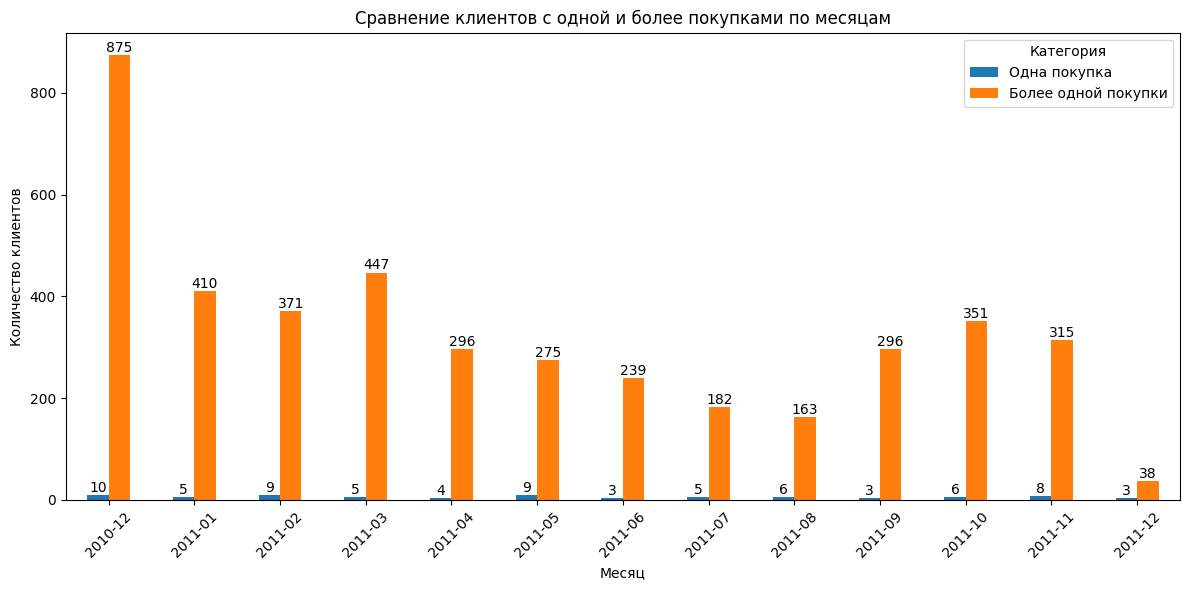

In [63]:
single_purchase_by_month = purchase_count[purchase_count['PurchaseCount'] == 1].groupby('FirstPurchaseMonth').size()
multiple_purchase_by_month = purchase_count[purchase_count['PurchaseCount'] > 1].groupby('FirstPurchaseMonth').size()
monthly_data = pd.DataFrame({
    'Одна покупка': single_purchase_by_month,
    'Более одной покупки': multiple_purchase_by_month
})
plt.figure(figsize=(12, 6))
ax4 = monthly_data.plot(kind='bar', stacked=False, ax=plt.gca())
text_for_barplot(ax4)
plt.xlabel('Месяц')
plt.ylabel('Количество клиентов')
plt.title('Сравнение клиентов с одной и более покупками по месяцам')
plt.xticks(rotation=45)
plt.legend(title='Категория')
plt.tight_layout()
plt.show()

Вроде нигде нет сосредоточения клиентов, которые сделали 1 покупку или какого-то перекоса между 1+ клиентами и клиентами с 1 покупкой. Смотреть это дело ещё по месяцам в формате Non-UK/UK не буду, потому что ранее мы узнали, что у нас только 4 клиента с 1 покупкой в Non-UK. Так что это будет бессмысленно. Также стоит отметить, что, видимо, и в правду есть опеределенное накопление клиентов со временем, потому что у нас очень много тех, кто несколько покупок сделал. Возможно, что у нас клиенты массово возвращались именно осенью 2011 года. Это пока логичнее всего выглядит. Но, возможен, и другой вариант, когда у нас просто очень высокий чек в эти месяца. Проверим это, посчитав средние чеки для наших когорт. В EDA мы уже видели, что в TotalAmount у распределения есть довольно-таки много больших значений, чтобы повлиять на среднее арифметическое, но недостаточно много, чтобы на основе этого мы могли сказать, что среднее арифметическое будет корректно отражать средний чек. Поэтому буду считать средний чек через медиану.

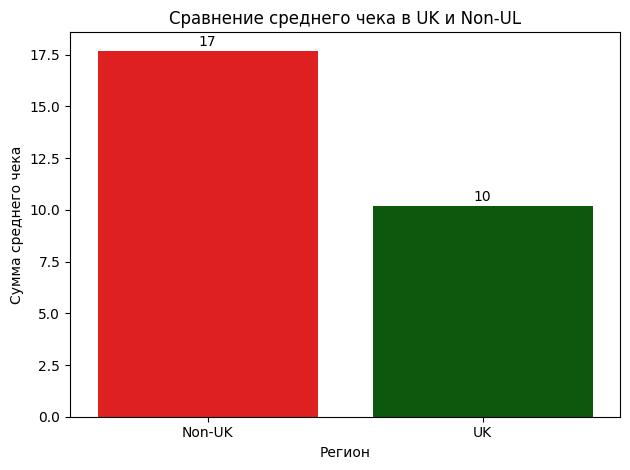

In [64]:
median_by_region = df_cleaned.groupby('Region')['TotalAmount'].median().reset_index()
median_by_region.columns = ['Регион', 'Сумма среднего чека']
ax5 = sns.barplot(x='Регион', y='Сумма среднего чека', hue='Регион', palette=['red', 'darkgreen'], data=median_by_region)
text_for_barplot(ax5)
plt.title('Сравнение среднего чека в UK и Non-UL')
plt.xlabel('Регион')
plt.ylabel('Сумма среднего чека')
plt.tight_layout()
plt.show()

Как я и предполагал ранее в EDA, средний чек в Non-Uk больше чем в UK, потому что ещё в EDA было видно, что на 18,5% дохода от общей массы приходилась на Non-UK, а количество транзакций равнялось 11,5%. Возможно, что это связано с тем, что в Non-UK более распространены траты на операции. В EDA мы выяснили, что у нас 2 самые прибыльные категории являются частью именно операций.
Теперь посмотрим на разделение по месяцам.

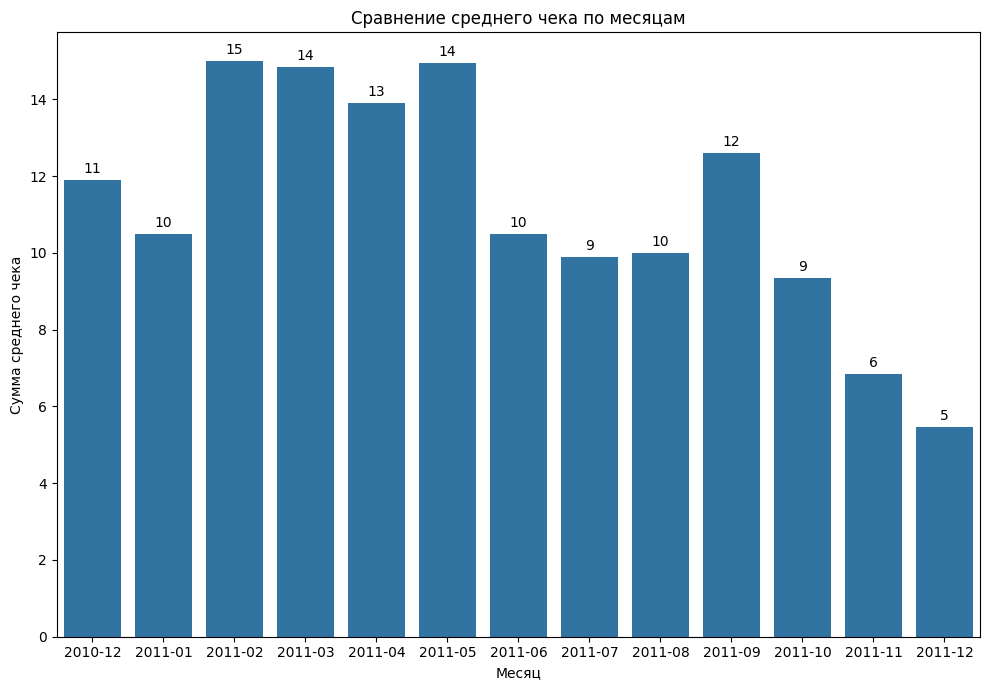

In [65]:
median_by_month = df_cleaned.groupby('FirstPurchaseMonth')['TotalAmount'].median().reset_index()
median_by_month.columns = ['Месяцы', 'Сумма среднего чека']
plt.figure(figsize=(10, 7))
ax6 = sns.barplot(x='Месяцы', y='Сумма среднего чека', data=median_by_month)
text_for_barplot(ax6)
plt.title('Сравнение среднего чека по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Сумма среднего чека')
plt.tight_layout()
plt.show()

Глобальный тренд тут наверное сложно увидеть, т.к. для этого желательно было бы два года иметь, но всё же видно, что после мая 2011 года идёт снижение среднего чека. Всё же это тревожный звоночек. Относительная стагнация по приходу новых клиентов и ещё то, что средний чек, видимо, падает указывает не на лучшую картину. Ещё аномально то, что рекордсмены по прибыли, т.е. осенние месяцы не особо выделяются по среднему чеку. Так что теперь я не удивлюсь, если увижу массовое возвращение клиентов именно в это время года.

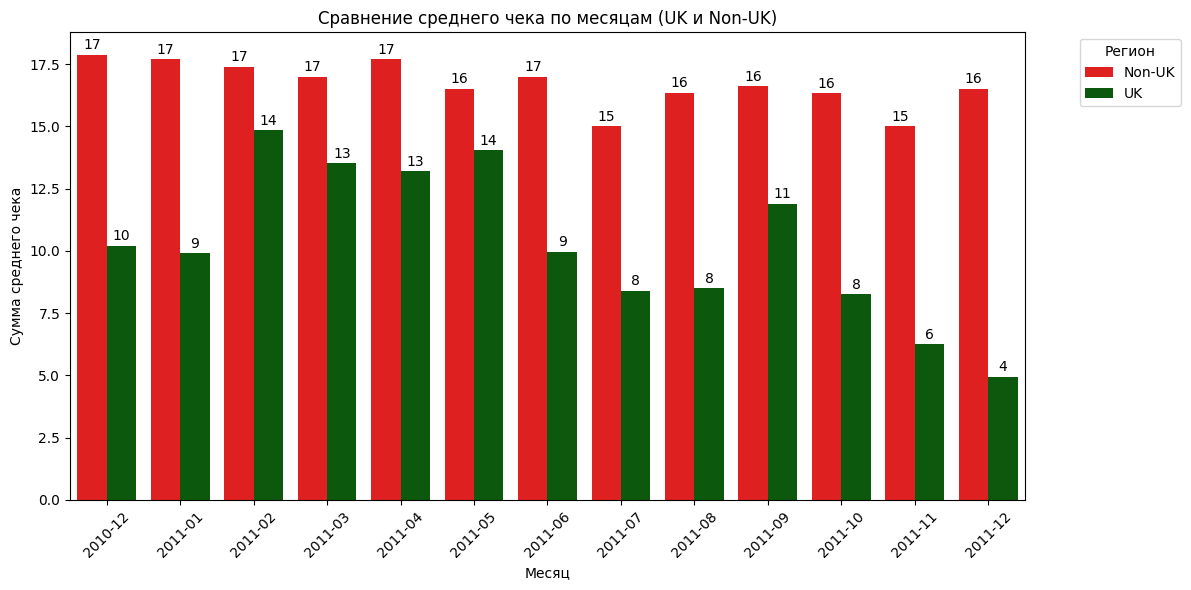

In [66]:
median_by_month_and_region = df_cleaned.groupby(['FirstPurchaseMonth', 'Region'])['TotalAmount'].median().reset_index()
median_by_month_and_region.columns = ['Месяцы', 'Регион', 'Сумма среднего чека']
plt.figure(figsize=(12, 6))
ax7 = sns.barplot(x='Месяцы', y='Сумма среднего чека', hue='Регион', data=median_by_month_and_region, palette=['red', 'darkgreen'])
text_for_barplot(ax7)
plt.title('Сравнение среднего чека по месяцам (UK и Non-UK)')
plt.xlabel('Месяц')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=45)
plt.legend(title='Регион', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Интересно, что у Non-UK средние чеки по месяцам примерно одинаковы и при этом ещё они везде больше чем у UK. Это позволяет нам лучше прогнозировать доходы на Non-UK и сосредоточить силы на UK клиентов, потому что у них ситуация менее стабильна и, возможно, даже имеет тенденцию к снижению, что в долгосроке сильно снизит доход, так как большая часть дохода зависит от UK.

Теперь посмотрим на среднее время между покупками. Это позволит нам посмотреть на среднюю частоту возвращения и лучше понимать и прогнозировать поведение клиентов. Будем считать через медиану, так как она устойчива к выбросам и лучше отражает типичного пользователя. Также будем считать именно с интервалом по дням, потому что это наиболее понятная единица измерения из которой состоят месяцы и год, но при этом не часы, потому что у нас возможно клиент совершает нескоько покупок в день и это исказит более длительное изучение поведение клиентов в долгосроке.
Получается, что мы отедлим транзакции, которые сделаны в один день от тех, где разница хотя бы день и анализировать будем именно вторые.

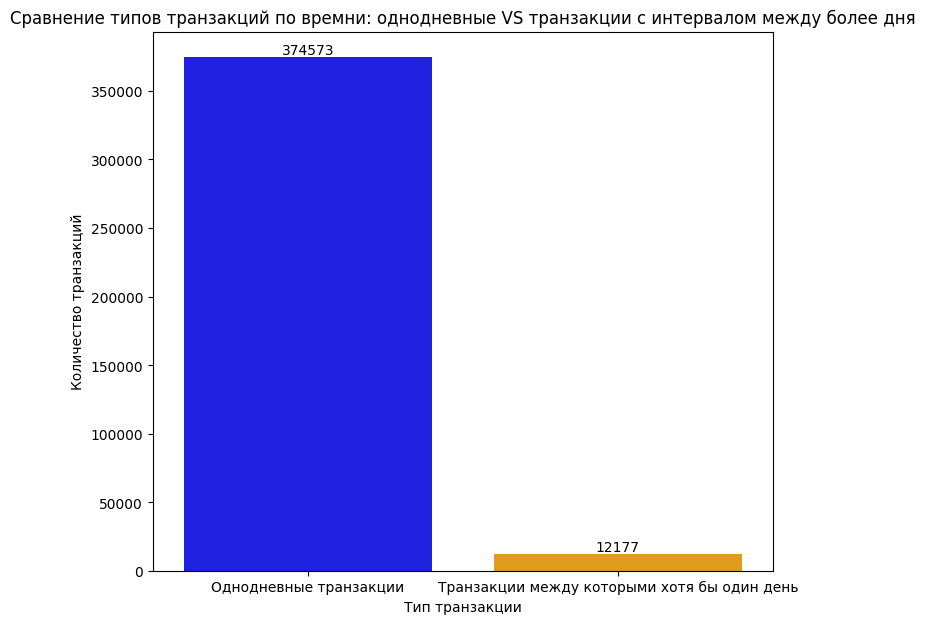

In [67]:
mini_df = df_cleaned[df_cleaned['IsProduct']].copy()
purchase_dates = mini_df[['CustomerID', 'InvoiceDate', 'FirstPurchaseMonth', 'Region']].copy()
purchase_dates = purchase_dates.sort_values(['CustomerID', 'InvoiceDate'])
purchase_dates['NextPurchase'] = purchase_dates.groupby('CustomerID')['InvoiceDate'].shift(-1)
purchase_dates['TimeDiff'] = (purchase_dates['NextPurchase'] - purchase_dates['InvoiceDate']).dt.days
intervals = purchase_dates[purchase_dates['TimeDiff'].notnull()]
one_day_transactions = intervals[intervals['TimeDiff'] == 0.0].shape[0]
multi_days_transactions = intervals[intervals['TimeDiff'] != 0.0].shape[0]
types_of_transactions = pd.DataFrame({'Тип транзакции': ['Однодневные транзакции', 'Транзакции между которыми хотя бы один день'],
                                     'Количество транзакций': [one_day_transactions, multi_days_transactions]})
plt.figure(figsize=(8, 7))
ax8 = sns.barplot(x='Тип транзакции', y='Количество транзакций', hue='Тип транзакции', data=types_of_transactions, palette=['blue', 'orange'])
text_for_barplot(ax8)
plt.title('Сравнение типов транзакций по времни: однодневные VS транзакции с интервалом между более дня')
plt.xlabel('Тип транзакции')
plt.ylabel('Количество транзакций')
plt.show()

Получается, что подовляющее число транзакций имеют между собой разницу меньше дня у одних и тех же клиентов. Возможно это связка транзакции с продуктом и транзакции с операцией, но в EDA мы выяснили, что у нас доля транзакций с операциями 0,4%, и я исключил их из подсчёта. Следовательно, этот вариант не подходит. Возможно, всё это обработка одной корзины, разные товары, но клиент купил их за сеанс. Это самое вероятное на первый взгляд.
Надеюсь, что это всё не про ситуацию, когда в первый раз клиент сделал большую покупку на много транзакций, а потом вернулся для разовых покупок, потому что тогда максимум на что можно надеяться, что они возвращаются и делают разовую транзакцию через более чем день, но всё же это всё равно не демонстрирует большой преданности клиентов. Буду надеяться, что это просто демонстрация того, что есть много разовых покупок сразу на много транзакций.
Более подробно мы сможем это изучить всё, когда будем retention смотреть, а сейчас мы смотрели именно в контексте подсчета среднего времени между заказами, и я скорее буду основываться в подсчёте именно на транзакции между которыми хотя бы день, чтобы лучше можно было в дальнейшем сделать временные отступы для исключения некоторых клиетов по времени из подсчёта retention, чтобы не исказить эту метику.
Продолжим подсчёт среднего времени между покупками. Посчитаем сначально глобально.

In [68]:
intervals = intervals[intervals['TimeDiff'] > 0]
global_time_median = intervals['TimeDiff'].median()
print(f'Глобальное среднее время между покупкаими: {global_time_median}')

Глобальное среднее время между покупкаими: 28.0


Теперь сравним Non-UK и UK

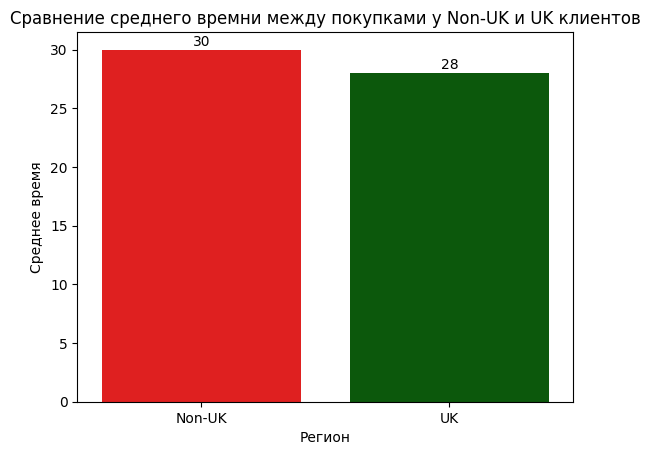

In [69]:
uk_and_non_uk_interval_median = intervals[['Region', 'TimeDiff']].groupby('Region').median().reset_index()
uk_and_non_uk_interval_median.columns = ['Регион', 'Среднее время между покупками']
ax9 = sns.barplot(x='Регион', y='Среднее время между покупками', hue='Регион', palette=['red', 'darkgreen'], data=uk_and_non_uk_interval_median)
text_for_barplot(ax9)
plt.title('Сравнение среднего времни между покупками у Non-UK и UK клиентов')
plt.xlabel('Регион')
plt.ylabel('Среднее время')
plt.show()

Отличие слабое, не факт, что оно значимо. Попробуем посмотреть его через тест Манна-Уитни, чтобы проверить стат значимость. Используем именно этот тест, потому что наше распределение не факт, что нормальное, а также из-за наличия вбросов, к которым непараметрический тест более устойчив.
Будем рассматривать, как нулевую гипотезу, то что медианы глобально одинаковы, а альтернативная, что различаются. Только перед этим посмотрим на распределения, чтобы точно сказать, что мы корректно выбрали тест Манна-Уитни.

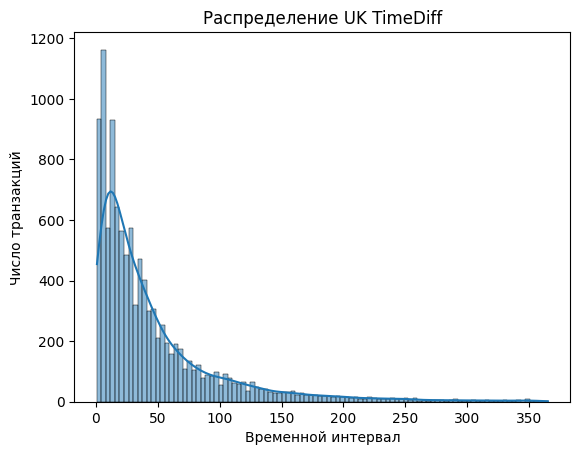

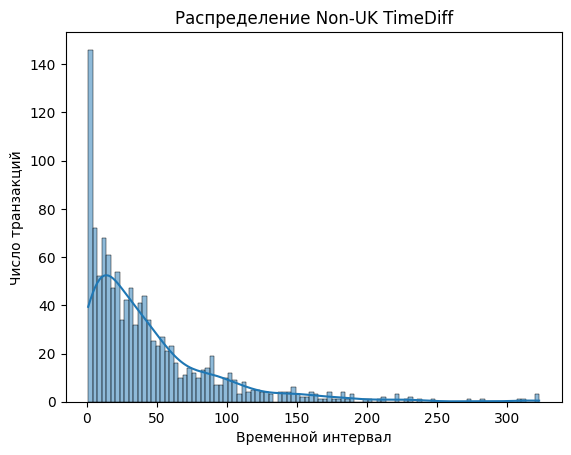

Статистика теста: 6401722.0, p-value: 0.9514655695028873
Различие в медианах времени между покупками не значимо (p >= 0.05).


In [70]:
uk_data = pd.to_numeric(intervals[intervals['Region'] == 'UK']['TimeDiff'])
non_uk_data = pd.to_numeric(intervals[intervals['Region'] != 'UK']['TimeDiff'])
sns.histplot(uk_data, bins=100, kde=True)
plt.title('Распределение UK TimeDiff')
plt.xlabel('Временной интервал')
plt.ylabel('Число транзакций')
plt.show()
sns.histplot(non_uk_data, bins=100, kde=True)
plt.title('Распределение Non-UK TimeDiff')
plt.xlabel('Временной интервал')
plt.ylabel('Число транзакций')
plt.show()
stat, p_value = scipy.stats.mannwhitneyu(uk_data, non_uk_data, alternative='two-sided')
print(f"Статистика теста: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Различие в медианах времени между покупками значимо (p < 0.05).")
else:
    print("Различие в медианах времени между покупками не значимо (p >= 0.05).")

Да, распределения схожи. Следовательно, подходит по критериям тест Манна-Уитни. Получается, что мы не можем отбросить нулевую гипотезу и не можем в точности опираться на то, что получили разные медианы. Получается, что когда будем выбирать левую границу для retention, то будем оперировать наибольшим значением. Также стоит учитывать, что для консервативной стратегии бизнесу стоит опираться на наименьшее значение, как для UK, так и для Non-UK, а для оптимистичной стратегии опираться на наибольшее значние. Но всё же наверное стоит упомянуть, то что данные только за 13 месяцев и возможно есть искажение со временем, т.е. что весь этот срок аномальный. По хорошему стоит знать бизнес контекст.
Теперь посмотрим на соотношения по месяцам.

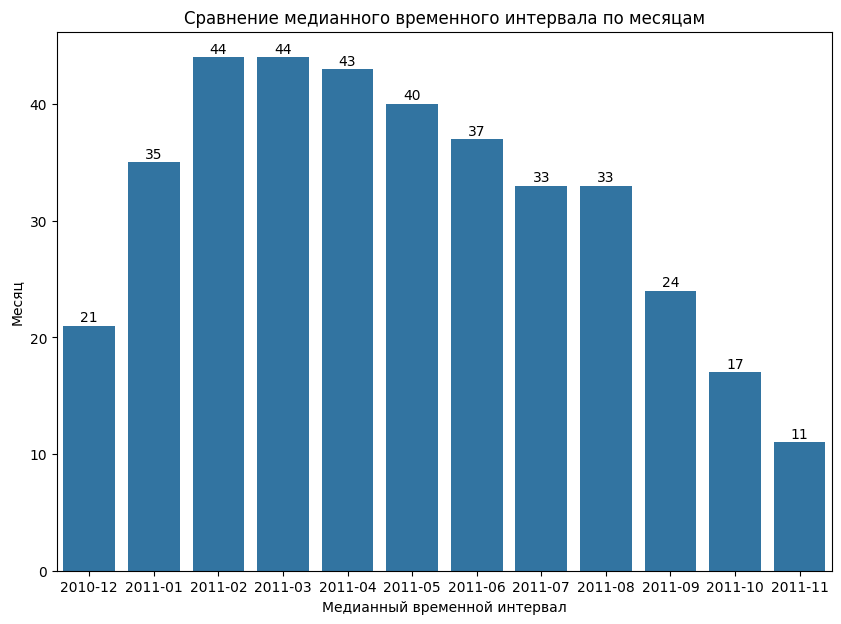

In [71]:
month_time_data = intervals.groupby('FirstPurchaseMonth')['TimeDiff'].median().reset_index()
month_time_data.columns = ['Месяц', 'Медианный временной интервал']
plt.figure(figsize=(10, 7))
ax10 = sns.barplot(x='Месяц', y='Медианный временной интервал', data=month_time_data)
text_for_barplot(ax10)
plt.title('Сравнение медианного временного интервала по месяцам')
plt.xlabel('Медианный временной интервал')
plt.ylabel('Месяц')
plt.show()

Тут тоже прослеживается некоторое падение со временом, но возможно, что оно из-за того, что последние когорты просто не успевают добрать достаточно клиентов. Хотя это может быть и не так, потому что всё же медиана более устойчива к вбросам и может быть достаточно большой и при небольшом количестве значений. В этом плане возможна и противоположная ситуация, где именно месяцы с наибольшей медианой аномалии. Я тут не буду проводить стат тесты, потому что я не знаю всей картины, вдруг бизнес проводил маркетинговую кампанию или прочее.
Теперь перейдем к просмотру этого ещё и в разрезе UK/Non-UK.

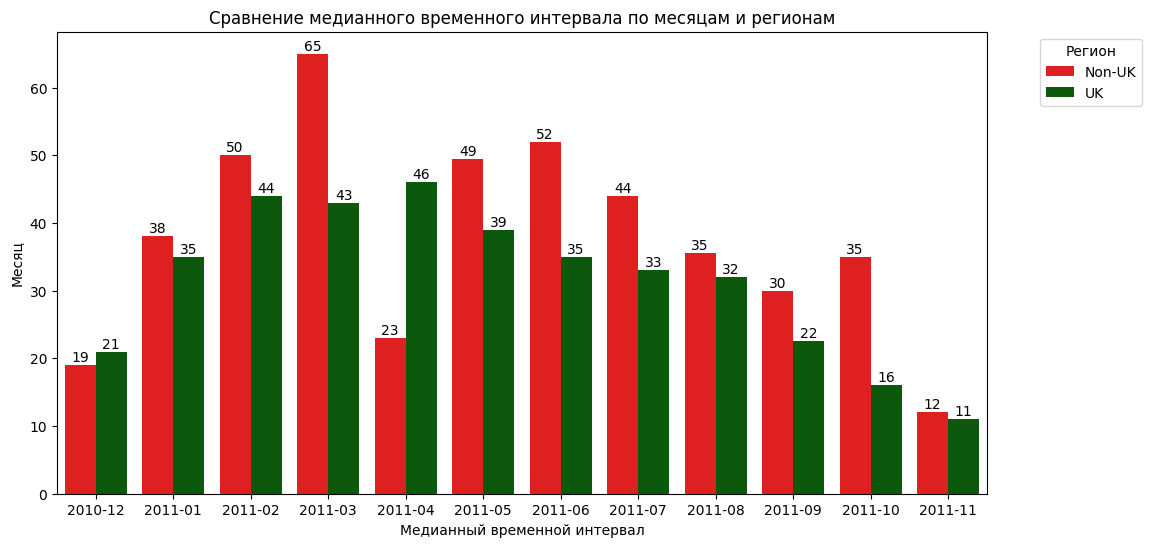

In [72]:
month_and_region_median_interval = intervals.groupby(['FirstPurchaseMonth', 'Region'])['TimeDiff'].median().reset_index()
month_and_region_median_interval.columns = ['Месяц', 'Регион', 'Медианный временной интервал']
plt.figure(figsize=(12, 6))
ax11 = sns.barplot(x='Месяц', y='Медианный временной интервал', hue='Регион', data=month_and_region_median_interval, palette=['red', 'darkgreen'])
text_for_barplot(ax11)
plt.title('Сравнение медианного временного интервала по месяцам и регионам')
plt.xlabel('Медианный временной интервал')
plt.ylabel('Месяц')
plt.legend(title='Регион', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Глобально мы видим, что Non-UK покупают реже чем UK за исключением декабря 2010 года и апреля 2011 года. Хотя глобально за весь период тест Манна-Уитни показал, что статистически значимого различия нет, но мы систематически его видим. Возможно, это из-за размера выборок, а также локальности данных и не знания локального бизнес контекста. Но всё же стоит это отличие отметить.
Может быть, стоит посмотреть по месячным когортнам и там именно внутри сравнить Non-Uk и UK, построить доверительные интервалы с помощью бутстрэпа. Но перед эти нужно понять, сколько кого, чтобы всё нормально работало. Если будет слишком мало, то пожалуй откажусь пока от этой идеи и просто оставлю в качестве одной из точек интереса

In [73]:
intervals.groupby(['FirstPurchaseMonth', 'Region']).size()

FirstPurchaseMonth  Region
2010-12             Non-UK     572
                    UK        5593
2011-01             Non-UK     215
                    UK        1353
2011-02             Non-UK      85
                    UK         961
2011-03             Non-UK      62
                    UK         949
2011-04             Non-UK      52
                    UK         520
2011-05             Non-UK      48
                    UK         427
2011-06             Non-UK      45
                    UK         336
2011-07             Non-UK      21
                    UK         211
2011-08             Non-UK      26
                    UK         147
2011-09             Non-UK      20
                    UK         250
2011-10             Non-UK      12
                    UK         187
2011-11             Non-UK       3
                    UK          82
dtype: int64

Всё же данных слишкоим мало, особенно в разрезе Non-UK после июля 2011 года. Так что думаю, что тесты не стоит проводить. Недостаток данных вместе с недостатком бизнес контекста вряд ли позволят это нормально сделать.
Перейдём к следующей метрике. Посчитаем среднее количество покупок на клиента сначала глобально. Перед этим стоит отметить то, что я буду учитывать именно многодневные покупки, т.е. покупки между, которыми хотя бы один день, потому что в противном случае у меня будет значительный перекос из-за того, что большая часть покупок совершенны в один день, а также мне нужно анализировать именно долгосрочное поведение. Считать буду через медиану, чтобы вбросы нивелировать.

In [74]:
num_purchase_days = mini_df.groupby('CustomerID')['PurchaseDay'].nunique().reset_index()
num_purchase_days.columns = ['CustomerID', 'NumPurchaseDays']
global_median_num_purchase_days = num_purchase_days['NumPurchaseDays'].median()
print(f'Медианное число покупок на пользователя: {global_median_num_purchase_days}')

Медианное число покупок на пользователя: 2.0


Получается если так глобально посмотреть на медианное число покупок и медианный промежуток времени, то медианно клиенты живут примерно месяц, потому что 28 дней медианный интервал и 2 покупки медианно делают они. Конечно, это нужно ещё проверить во время подсчёта retention и более детального просмотра когорт, но всё же отметим это. Теперь посмотрим на медианы UK и Non-UK.

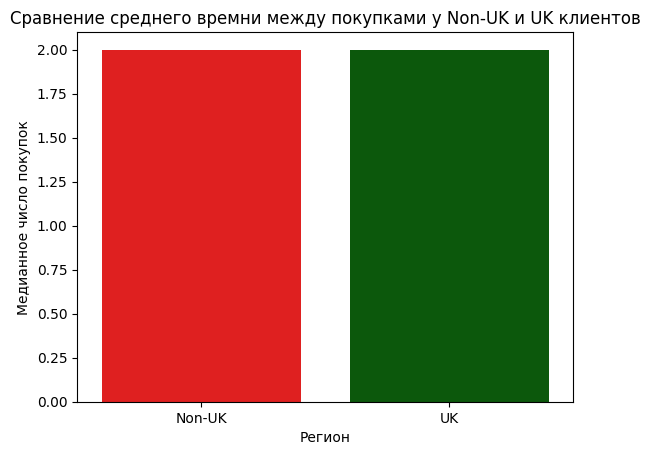

,Регион,Медианное число покупок
0,Non-UK,2.0
1,UK,2.0


In [75]:
customer_region = mini_df.groupby('CustomerID')['Region'].first().reset_index()
customer_month = mini_df.groupby('CustomerID')['FirstPurchaseMonth'].first().reset_index()
purchases_counts_per_users = num_purchase_days.merge(customer_region, on='CustomerID', how='left')
purchases_counts_per_users = purchases_counts_per_users.merge(customer_month, on='CustomerID', how='left')
uk_and_non_uk_purchases_median = purchases_counts_per_users.groupby('Region')['NumPurchaseDays'].median().reset_index()
uk_and_non_uk_purchases_median.columns = ['Регион', 'Медианное число покупок']
ax12 = sns.barplot(x='Регион', y='Медианное число покупок', hue='Регион', palette=['red', 'darkgreen'], data=uk_and_non_uk_purchases_median)
plt.title('Сравнение среднего времни между покупками у Non-UK и UK клиентов')
plt.xlabel('Регион')
plt.ylabel('Медианное число покупок')
plt.show()
uk_and_non_uk_purchases_median

Теперь хочется более точно понять реально ли сходство или это просто совпадение. Попробуем провести тест Манна-Уитни для этого, но сначала проверим распределение.

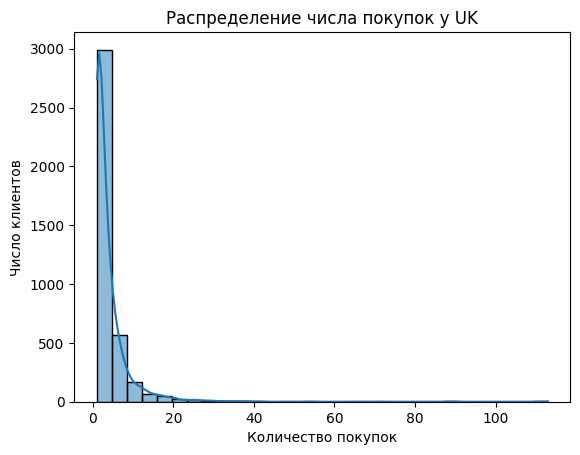

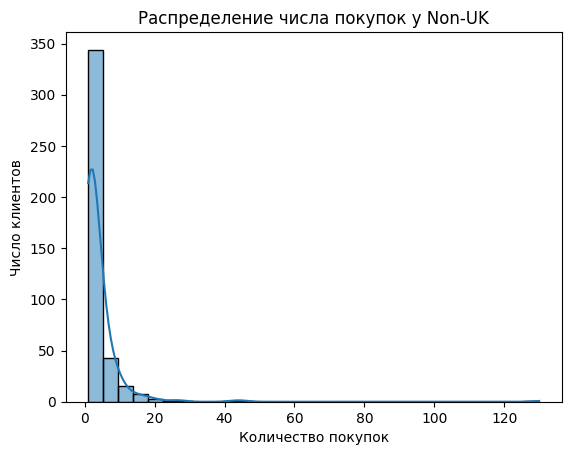

In [76]:
uk_median_purchases_data = purchases_counts_per_users[purchases_counts_per_users['Region'] == 'UK']
non_uk_median_purchases_data = purchases_counts_per_users[purchases_counts_per_users['Region'] == 'Non-UK']
sns.histplot(data=uk_median_purchases_data, x='NumPurchaseDays', bins=30, kde=True)
plt.title('Распределение числа покупок у UK')
plt.ylabel('Число клиентов')
plt.xlabel('Количество покупок')
plt.show()
sns.histplot(data=non_uk_median_purchases_data, x='NumPurchaseDays', bins=30, kde=True)
plt.title('Распределение числа покупок у Non-UK')
plt.ylabel('Число клиентов')
plt.xlabel('Количество покупок')
plt.show()

Распределения похожи и при этом не нормальные, а также есть вбросы. Пусть нулевой гипотезой будет то, что медианы равны, а альтернативной, что они различаются. Попробуем проверить это с помощью теста Манна-Уитни.

In [77]:
stat, p_value = scipy.stats.mannwhitneyu(uk_median_purchases_data['NumPurchaseDays'], non_uk_median_purchases_data['NumPurchaseDays'], alternative='two-sided')
print(f"Статистика теста: {stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Различие в медианах времени между покупками значимо (p < 0.05).")
else:
    print("Различие в медианах времени между покупками не значимо (p >= 0.05).")

Статистика теста: 837167.0, p-value: 0.42787588218928274
Различие в медианах времени между покупками не значимо (p >= 0.05).


Получается, что мы не можем отбросить нулевую гипотезу. Это конечно не значит, что медианы глобально равны, но всё же оснований принимать альтернативную гипотезу нет.
Теперь посмотрим в разрезе месяцев. Думаю, что увижу снижении медианы, потому что меньше времени прошло у последних месяцев.

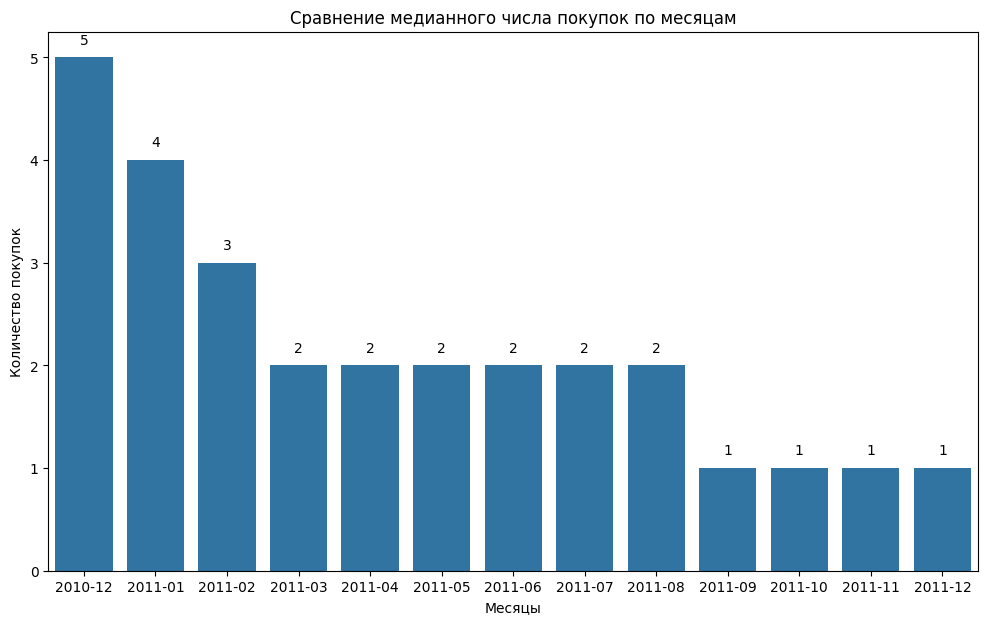

In [78]:
month_median_purchases_data = purchases_counts_per_users.groupby('FirstPurchaseMonth')['NumPurchaseDays'].median().reset_index()
month_median_purchases_data.columns = ['Месяц', 'Медианное число покупок']
plt.figure(figsize=(12, 7))
ax13 = sns.barplot(x='Месяц', y='Медианное число покупок', data=month_median_purchases_data)
text_for_barplot(ax13)
plt.title('Сравнение медианного числа покупок по месяцам')
plt.ylabel('Количество покупок')
plt.xlabel('Месяцы')
plt.show()

В принципе, всё как и предполагалось. Постепенно снижается медиана, но это скорее всего из-за того, что у клиентов из последних месячных когорт времени меньше на покупки и поэтому меньше они купиили. Теперь посмотрим ещё и в разрезе UK/Non-UK.

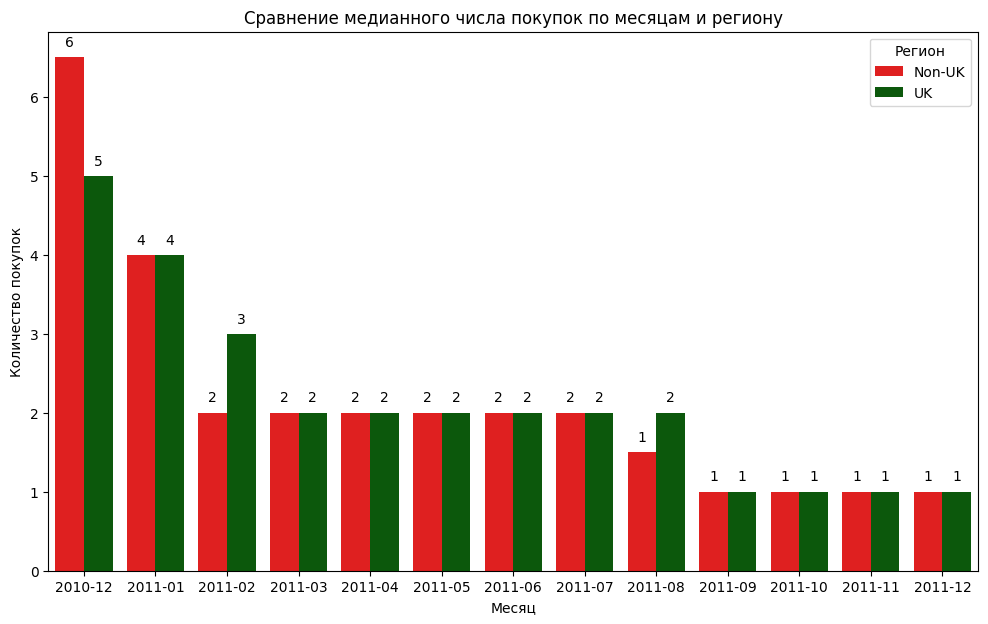

In [79]:
month_and_region_median_purchase_data = purchases_counts_per_users.groupby(['FirstPurchaseMonth', 'Region'])['NumPurchaseDays'].median().reset_index()
month_and_region_median_purchase_data.columns = ['Месяц', 'Регион', 'Медианное число покупок']
plt.figure(figsize=(12, 7))
ax14 = sns.barplot(x='Месяц', y='Медианное число покупок', hue='Регион', data=month_and_region_median_purchase_data, palette=['red', 'darkgreen'])
text_for_barplot(ax14)
plt.title('Сравнение медианного числа покупок по месяцам и региону')
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')
plt.show()

Более детально тоже не видно какого-нибудь аномального скачка. Получается, что скорее всё же есть угасание и нет каких-то сверхактивных когорт в конце. Возможно, что UK более активны, видно, что они медленнее теряют количество покупок по мере приближения когорты к концу наблюдения. Но это скорее точка интереса на будущее, рано тут что-то говорить. Будет яснее, когда retention буду смотреть.
Перейдём теперь к ARPU. Посмотрим сначала в разрезе UK/Non-Uk.

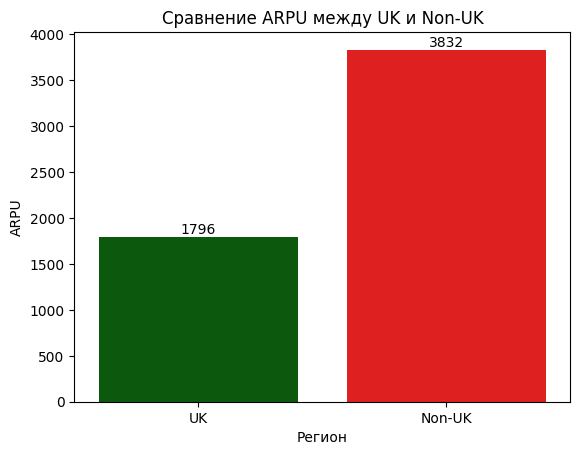

In [82]:
non_uk_unique_customers = df_cleaned[df_cleaned['Region'] == 'Non-UK']['CustomerID'].nunique()
uk_unique_customers = df_cleaned[df_cleaned['Region'] == 'UK']['CustomerID'].nunique()
non_uk_revenue = df_cleaned[df_cleaned['Region'] == 'Non-UK']['TotalAmount'].sum()
uk_revenue = df_cleaned[df_cleaned['Region'] == 'UK']['TotalAmount'].sum()
uk_arpu = (uk_revenue / uk_unique_customers).round(2)
non_uk_arpu = (non_uk_revenue / non_uk_unique_customers).round(2)
uk_and_non_uk_arpu = pd.DataFrame({'Регион': ['UK', 'Non-UK'],
                                   'ARPU': [uk_arpu, non_uk_arpu]})
ax15 = sns.barplot(x='Регион', y='ARPU', hue='Регион', data=uk_and_non_uk_arpu, palette=['darkgreen', 'red'])
text_for_barplot(ax15)
plt.title('Сравнение ARPU между UK и Non-UK')
plt.ylabel('ARPU')
plt.xlabel('Регион')
plt.show()

Non-UK имеют гораздо более высокий ARPU по тому, что мы видим, но всё же хочется понять насколько всё это систематическим может быть. Посмотрим на распределения доходов на клиентов и дальше решим, что применять.

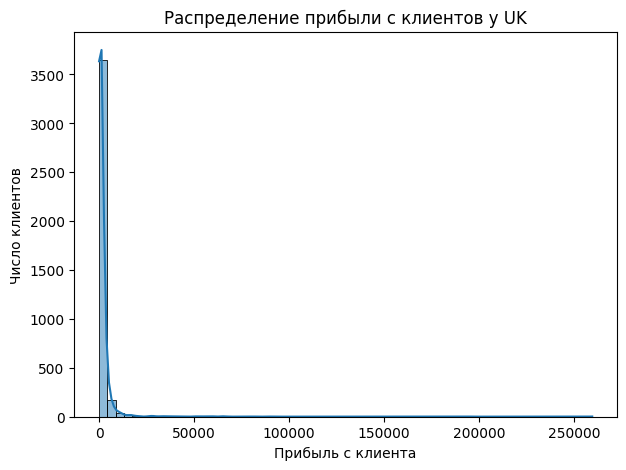

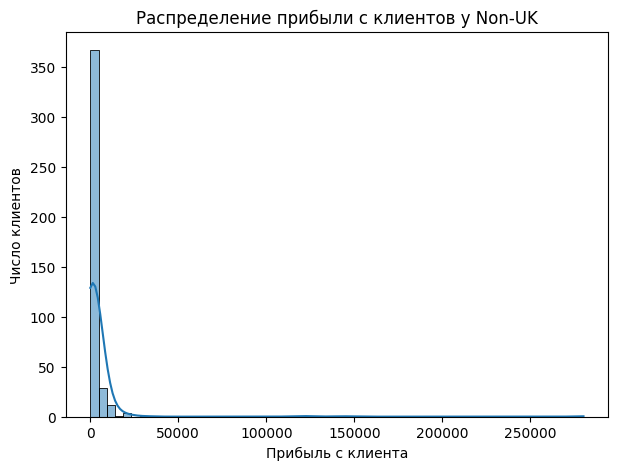

In [83]:
totalamount_per_customer = df_cleaned.groupby(['CustomerID', 'Region'])['TotalAmount'].sum().reset_index(name='TotalSumAmount')
uk_totalamount_per_customer = totalamount_per_customer[totalamount_per_customer['Region'] == 'UK']
non_uk_totalamount_per_customer = totalamount_per_customer[totalamount_per_customer['Region'] == 'Non-UK']
plt.figure(figsize=(7, 5))
sns.histplot(data=uk_totalamount_per_customer['TotalSumAmount'], bins=60, kde=True)
plt.title('Распределение прибыли с клиентов у UK')
plt.ylabel('Число клиентов')
plt.xlabel('Прибыль с клиента')
plt.show()
plt.figure(figsize=(7, 5))
sns.histplot(data=non_uk_totalamount_per_customer['TotalSumAmount'], bins=60, kde=True)
plt.title('Распределение прибыли с клиентов у Non-UK')
plt.ylabel('Число клиентов')
plt.xlabel('Прибыль с клиента')
plt.show()

Данные распределены не нормально. Сейчас мы смотрим именно среднее арифметическое, а не медиану. Следовательно, попробуем понять через bootstrap стат значимо ли отличие между ARPU для разных регионов или нет. В качестве нулевой гипотезы будет то, что они одинаковы, а в качестве альтернативной их отличие.

In [84]:
def bootstrap_for_mean_pvalue(data1, data2, n_bootstrap=10000, alpha=0.05):
    differences = list()
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(data1.values, size=data1.shape[0], replace=True)
        sample2 = np.random.choice(data2.values, size=data2.shape[0], replace=True)
        diff = np.mean(sample1) - np.mean(sample2)
        differences.append(diff)
    observed_difference = np.mean(data1) - np.mean(data2)
    two_side_p_value = 2 * min(sum(dif <= observed_difference for dif in differences) / n_bootstrap,
                  sum(dif >= observed_difference for dif in differences) / n_bootstrap)
    ci_lower = np.percentile(differences, 100 * alpha / 2)
    ci_upper = np.percentile(differences, 100 * (1 - alpha / 2))
    return two_side_p_value, ci_lower, ci_upper


p_value, ci_lower, ci_upper = bootstrap_for_mean_pvalue(uk_totalamount_per_customer['TotalSumAmount'], non_uk_totalamount_per_customer['TotalSumAmount'])
print(f'p-value = {p_value}')

p-value = 0.9308


p-value говорит, что мы не можем отбросить нулевую гипотезу, но значение равное примерно 0,9 странное в контексте того, чему ранвы ARPU у UK/Non-UK. Хочу посмотреть более подробно информацию про uk_totalamount_per_customer['TotalSumAmount'] и non_uk_totalamount_per_customer['TotalSumAmount'], чтобы понять чем это может быть обусловлено.

In [85]:
summary = pd.DataFrame({
    'UK': uk_totalamount_per_customer['TotalSumAmount'].describe(),
    'Non-UK': non_uk_totalamount_per_customer['TotalSumAmount'].describe()
})

print(summary)

                  UK         Non-UK
count    3916.000000     418.000000
mean     1796.839128    3832.976675
std      6887.897917   17621.307220
min         2.900000      51.560000
25%       297.750000     457.975000
50%       644.100000    1031.995000
75%      1567.532500    2705.637500
max    259657.300000  280206.020000


Теперь понятнее всё стало. Можно чётко сказать, что за этот период Non-UK в среднем платят больше, но вот глобально отличие не стат значимо, но это скорее всего именно из-за огромных значений стандартного отклонения, из-за огромной разницы стандартных отклонений, огромного отличия у count. Т.е. средние оказались нестабильными.
Перейдём к просмотру в разрезе месяцев.

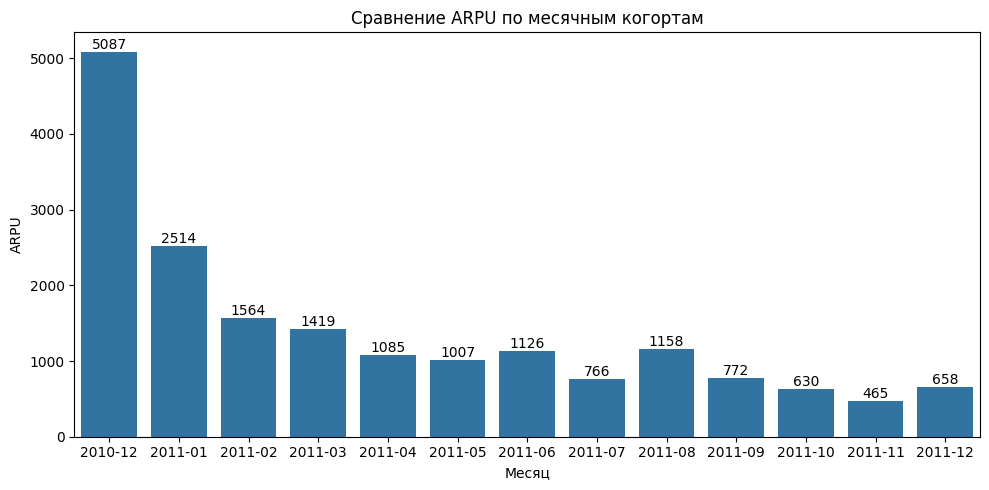

In [86]:
customers_total_sum_amount = totalamount_per_customer.merge(df_cleaned[['CustomerID', 'FirstPurchaseMonth']].drop_duplicates(),
                                                                 on='CustomerID',
                                                                 how='left')
month_total_sum_per_customer = customers_total_sum_amount.groupby('FirstPurchaseMonth')['TotalSumAmount'].mean().reset_index()
month_total_sum_per_customer.columns = ['Месяц', 'ARPU']
plt.figure(figsize=(10, 5))
ax16 = sns.barplot(x='Месяц', y='ARPU', data=month_total_sum_per_customer)
text_for_barplot(ax16)
plt.title('Сравнение ARPU по месячным когортам')
plt.tight_layout()
plt.show()

У нас явно есть тенденция к угасанию ARPU у более поздних когорт и аномальный скачок в декабре 2010. Я бы предположил, что это связанно с новогодними праздниками, но, как мы знаем из EDA, у нас нет данных по новогодним праздникам. Получается эта теория отпадает. Сравнить с декабрём 2011 не получится, потому что у нас неполные данные за декабрь 2011, точнее у нас половина месяца отсутствует. Виднен локальный рост в июне 2011, августе 2011 и декабре 2011. В остальные месяцы у нас спад. Отметим декабрь 2011, как потенциальную точку интереса, чтобы в будущем компания смогла собрать по нему побольше данных и можно было лучше понять насколкько типична ситуация с ростом ARPU в этой месячной когорте. Возможно, такое снижение обусловленно тем, что самые ранние когорты имеют больше доступа к большему числу праздников в течении года. Это косвенно можно будет проверить, когда я retention считать буду. Нужно обратить внимание на активность когорт в праздники и так понять есть ли между этим связь. Хотя конечно это всё может объясняться и другим, но примем это пока, как основную мысль. Правда эта мысль объяснить может общее снижение, но не объясняет скачки в трёх аномальных месяцах. Это конечно может быть просто случайность, но всё же интересно будет понаблюдать за этими когортами.
Теперь посмотрим ещё в разрезе месяцев и региона.

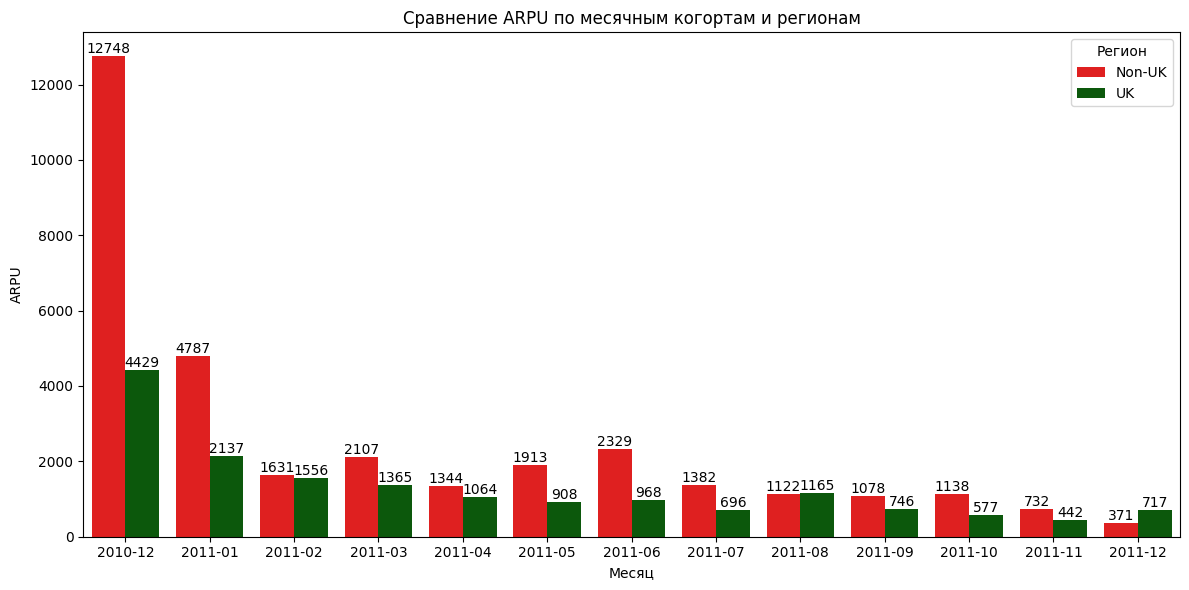

In [87]:
month_total_sum_per_customer = customers_total_sum_amount.groupby(['FirstPurchaseMonth', 'Region'])['TotalSumAmount'].mean().reset_index()
month_total_sum_per_customer.columns = ['Месяц', 'Регион', 'ARPU']
plt.figure(figsize=(12, 6))
ax16 = sns.barplot(x='Месяц', y='ARPU', hue='Регион', data=month_total_sum_per_customer, palette=['red', 'darkgreen'])
text_for_barplot(ax16)
plt.title('Сравнение ARPU по месячным когортам и регионам')
plt.tight_layout()
plt.show()

Почти во всех месяцах кроме августа 2011 и декабря 2011 и инюня 2011 спад у UK клиентов. Интересно, что тут есть пересечение с аномальными месяцами, если чисто ARPU по месяцам смотреть. Видимо, это связано. Кроме того, если смотреть изменения ARPU по месяцам у разных регионов, то падение не такое стабильное, как чисто по месяцам. Особенно это касается Non-UK, где под силой падения я подразумеваю количество месяцев с ростом ARPU. Вообще, если глобально смотреть по тому, что я уже знаю глобально из анализа про Non-UK, то можно уже предполагать, что они могут неплохим тылом и денежной базой послужить, пока бизнес восстановит показатели и лояльность у UK клиентов, которые всё же являются основной массой. Но пока ещё рано выводы делать. Интересно на retention посмотреть и после этого уже картина станет яснее.
Собственно говоря, перейдём рассчёту Return Retention. Я не буду смотреть на метрики, связанные с retention, чисто в разрезе UK/Non-UK, потому что всё же чисто этот разрез не по времени и многое нормально отследить не получится. Получается буду смотреть чисто по месяцам и по месяцам и региону для более детального просмотра. Ещё нужно уточнить, что не стоит особо внимания обращать на последние две месячные когорты, потому что у нас медианное время равно 28-30, если смотреть глобально по регионам и 2 покупки в среднем. Получается, что один месяц полностью отпадает, а ещё во внимание нужо взять, что декабрь 2011 неполный, так что смотрим именно на другие месячные когорты, а ноябрь 2011 и декабрь 2011 смотрим чисто на возвращения в эти месяцы.

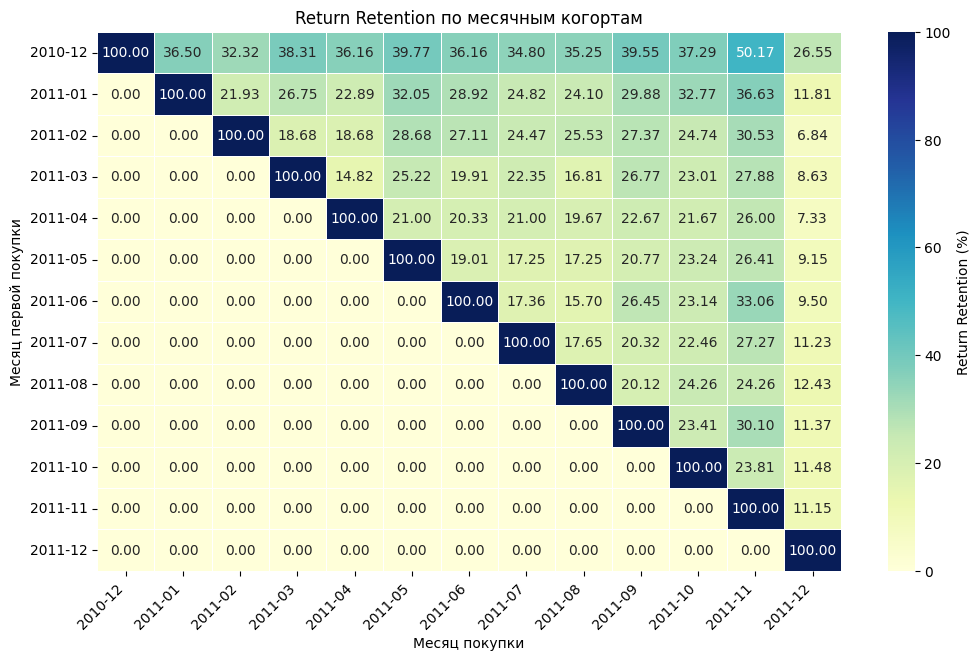

In [123]:
def calculate_retention(df):
    month_cohort_data = df.groupby(['FirstPurchaseMonth', 'Month'])['CustomerID'].nunique().reset_index()
    month_cohort_counts = month_cohort_data.pivot(index='FirstPurchaseMonth', columns='Month', values='CustomerID')
    month_cohort_size = df.groupby('FirstPurchaseMonth')['CustomerID'].nunique()
    month_return_retention = month_cohort_counts.divide(month_cohort_size, axis=0) * 100
    month_return_retention = month_return_retention.fillna(0)
    month_return_retention = month_return_retention.round(2)
    return month_return_retention


month_return_retention = calculate_retention(mini_df)
plt.figure(figsize=(12, 7))
sns.heatmap(month_return_retention, annot=True, fmt='.2f', cmap='YlGnBu',
            cbar_kws={'label': 'Return Retention (%)'},
            linewidths=0.5)
plt.title('Return Retention по месячным когортам')
plt.xlabel('Месяц покупки')
plt.ylabel('Месяц первой покупки')
plt.xticks(rotation=45, ha='right')
plt.show()

В ноябрь 2011 года клиенты из месячных когорт возвращаются чаще всего. Так что мысль, которую я высказывал ранее в ходе анализа подтвердилась, у нас и в правду когорты массово возвращаются в ноябре 2011 и, видимо, именно это обуславливает, что это самый прибыльный месяц, потому что ранее мы выяснили, что ноябрь по факту кроме аномального дохода в этот месяц ничем особенно не выделяется и таким образом оставалась только эта теория с тем, что клиенты массово возвращаются. Теперь же понятно, что влечет такую прибыль. Также интересно, что декабрьская когорта, видимо, самая преданная и при этом самая крупная. Было бы интересно посмотреть на преданность клиентов из когорты декабря 2011 года, если бы данные были полными и был бы ещё один год информации. Тогда имея ещё бизнес контекст можно было бы сравнить лучше. Отметим это просто, как точку интереса. Мне кажется, что первые когорты в хронологическом порядке имеют большую преданность. Но это всё же стоит проверить численно. Подсчитаем для них средний и медианный return retention.

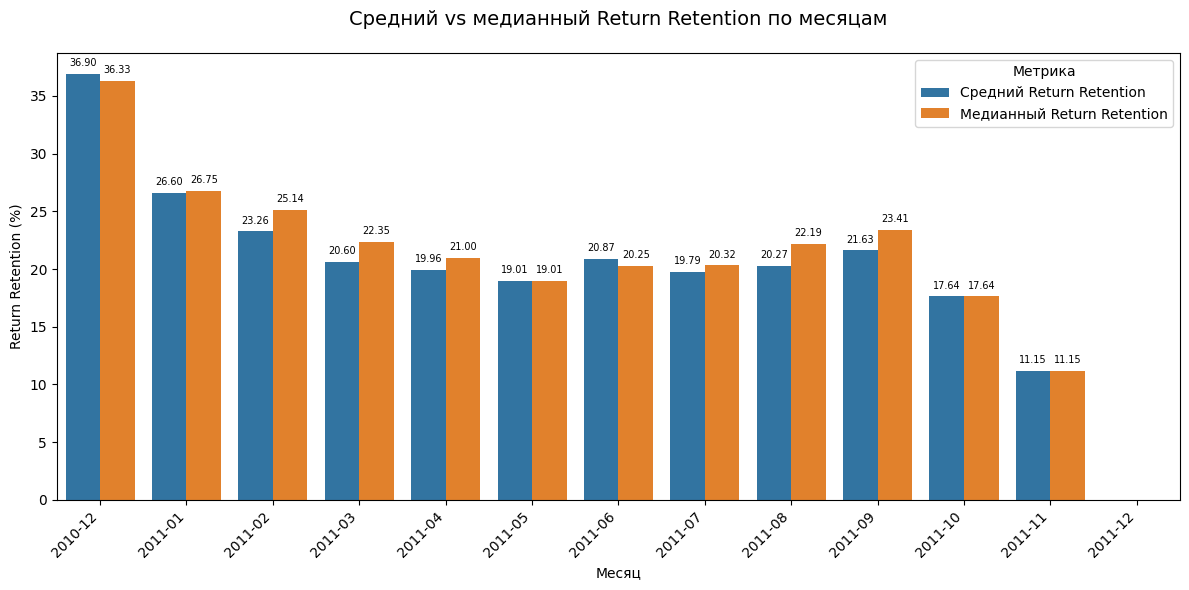

In [135]:
def medians_and_means_return_retentions(return_retention):
    means, medians = list(), list()
    month_names_list = month_return_retention.columns.tolist()
    for return_retentions in return_retention.values:
        return_retentions = [i for i in return_retentions if i != 100 and i != 0]
        if return_retentions:
            median_return_retentions = np.median(return_retentions).round(2)
            mean_return_retentions = np.mean(return_retentions).round(2)
        else:
            median_return_retentions = 0
            mean_return_retentions = 0
        means.append(mean_return_retentions)
        medians.append(median_return_retentions)
    means_and_medians_data_frame = pd.DataFrame({'Месяц': month_names_list,
                                    'Средний Return Retention': means,
                                      'Медианный Return Retention': medians})
    means_and_medians_data_frame = means_and_medians_data_frame.fillna(0)
    melted_df = means_and_medians_data_frame.melt(id_vars='Месяц', 
                                                  value_vars=['Средний Return Retention', 'Медианный Return Retention'],
                                                  var_name='Метрика', 
                                                  value_name='Return Retention')
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=melted_df, x='Месяц', y='Return Retention', hue='Метрика', palette=['#1f77b4', '#ff7f0e'])
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height + 0.5, f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=7)
    plt.title('Средний vs медианный Return Retention по месяцам', fontsize=14, pad=20)
    plt.xlabel('Месяц')
    plt.ylabel('Return Retention (%)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Метрика')
    plt.tight_layout()
    plt.show()
    return means, medians

    
month_retention_means, month_retention_medians = medians_and_means_return_retentions(month_return_retention)

Да, как мы и предполагали. Первые месячные когорты имеют лучшие показатели по return retention и если смотреть глобально, то они самые преданные. Также тут прослеживается тенденция к возвращению преданность, начиная с июня 2011, хотя всё же данных недостаточно и если бы был ещё один год или полтора года, то можно было бы лучше сезонность рассмотреть. Просто отметим, как точку интереса. Ещё стоит отметить, что между средним и медианной не такая уж и большая разница, и иногда она меньше 1%.
Перейдём дальше к просмотру в разрезе региона и UK/Non-UK. Выведем 2 heatmap для регионов. Потом сравним поведение клиентов, чтобы понять были ли наши предыдущие предположения о большей лояльности Non-UK правдой.

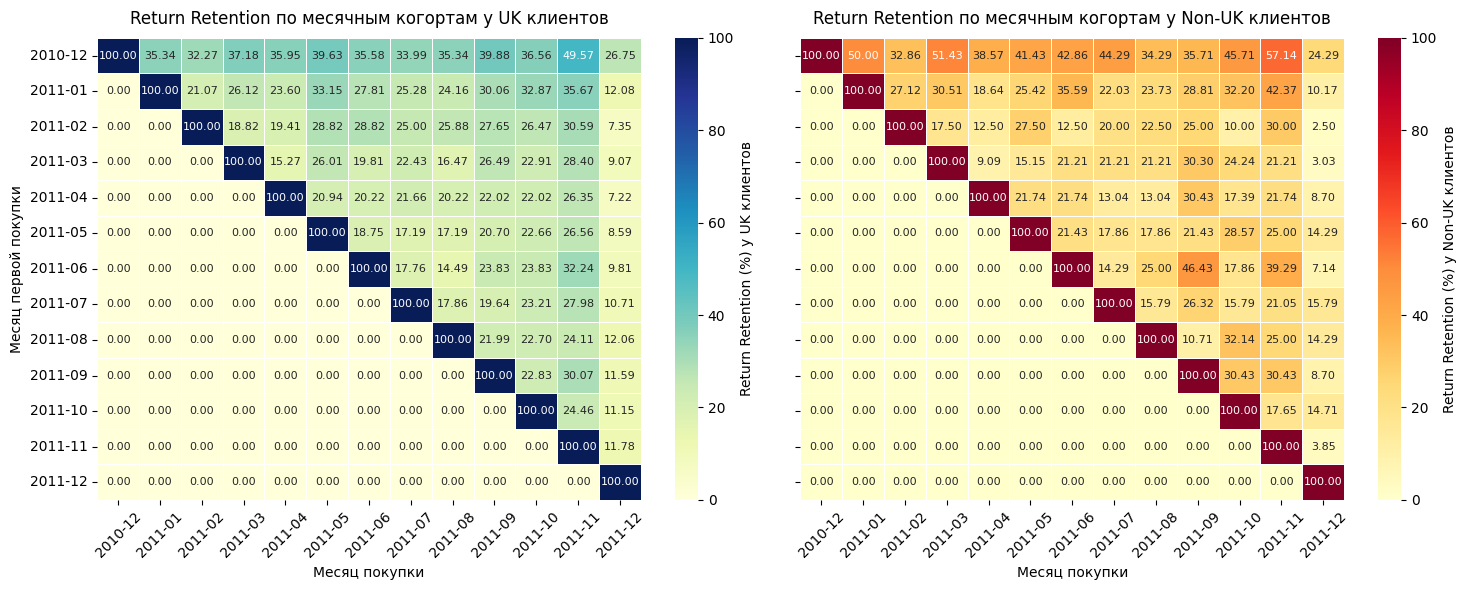

In [126]:
uk_data_for_retention = mini_df[mini_df['Region'] == 'UK']
non_uk_data_for_retention = mini_df[mini_df['Region'] == 'Non-UK']
uk_month_return_retention = calculate_retention(uk_data_for_retention)
non_uk_month_return_retention = calculate_retention(non_uk_data_for_retention)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.heatmap(uk_month_return_retention, annot=True, fmt='.2f', cmap='YlGnBu',
            cbar_kws={'label': 'Return Retention (%) у UK клиентов'},
            linewidths=0.5, ax=ax1, annot_kws={'size': 8})
ax1.set_title('Return Retention по месячным когортам у UK клиентов', fontsize=12, pad=10)
ax1.set_xlabel('Месяц покупки')
ax1.set_ylabel('Месяц первой покупки')
ax1.tick_params(axis='x', rotation=45, labelsize=10)
sns.heatmap(non_uk_month_return_retention, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Return Retention (%) у Non-UK клиентов'},
            linewidths=0.5, ax=ax2, annot_kws={'size': 8})
ax2.set_title('Return Retention по месячным когортам у Non-UK клиентов', fontsize=12, pad=10)
ax2.set_xlabel('Месяц покупки')
ax2.set_ylabel('')
ax2.tick_params(axis='x', rotation=45, labelsize=10)
plt.tight_layout()
plt.show()

Видимо, что когорта декабря 2010 года является самой активновной и преданной, как в разрезе UK, так и Non-UK. Также оба разреза проявляют высокую активность и возвращение в осенние месяцы. Отдельно провизуализируем группы, может быть, что-то интересное увидим. Интересно посмотреть на их активность в этом разрезе.

Медианные и средние значения у UK клиентов:


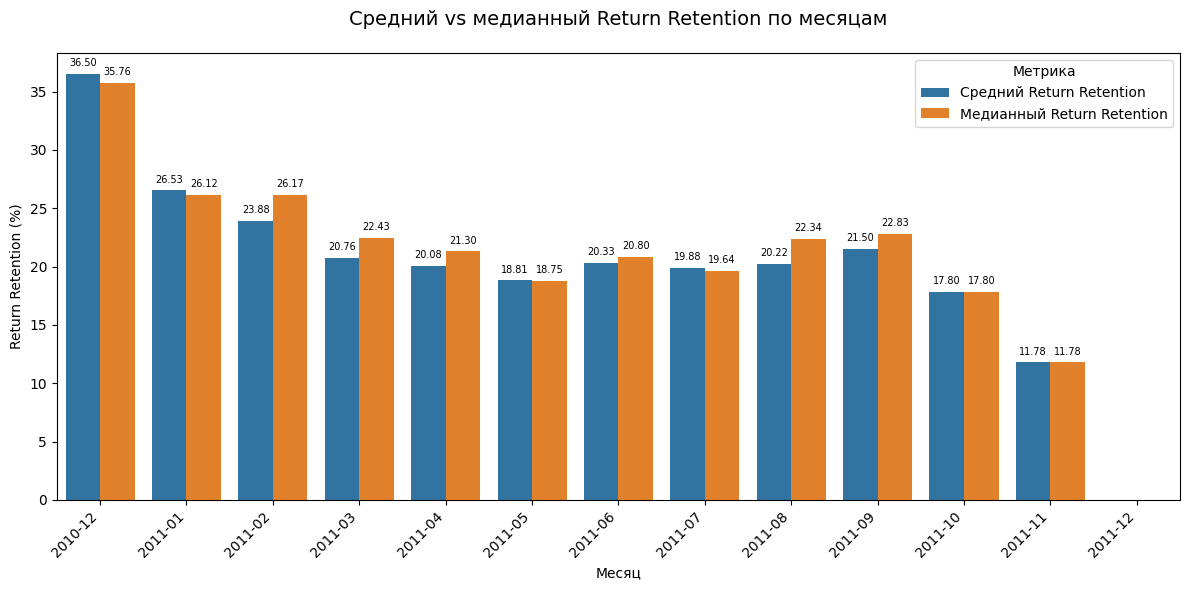

Медианные и средние значения у Non-UK клиентов:


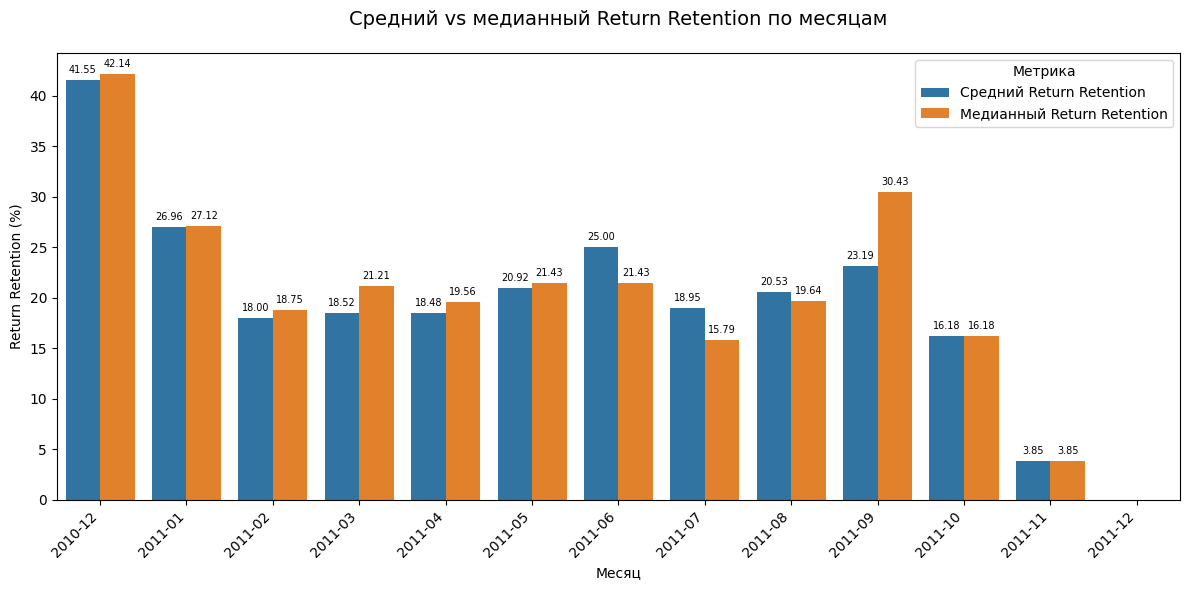

In [131]:
print(f'Медианные и средние значения у UK клиентов:')
uk_medians, uk_means = medians_and_means_return_retentions(uk_month_return_retention)
print(f'Медианные и средние значения у Non-UK клиентов:')
non_uk_medians, non_uk_means = medians_and_means_return_retentions(non_uk_month_return_retention)

Тут UK-клиенты как будто большую стабильность имеют в плане среднего и медианного return retention. По ощущениям Non-UK всё же будут иметь большую глобальную медиану или среднее, поэтому мне кажется, что всё же интересно ещё посмотреть на глобальную медиану по медианам и потом ещё по средним, чтобы типичный return retention увидеть.

In [137]:
print(f'Медиана по медианам UK: {np.median(uk_medians)}',
      f'Медиана по средним UK: {np.median(uk_means)}',
      f'Медиана по медианам Non-UK: {np.median(non_uk_medians)}',
      f'Медиана по средним Non-UK: {np.median(non_uk_means)}', sep='\n')

Медиана по медианам UK: 20.22
Медиана по средним UK: 21.3
Медиана по медианам Non-UK: 18.95
Медиана по средним Non-UK: 19.64


Я ошибся. Получается, что return retention у Non-UK медианно ниже чем у UK, но различия минимальны. Получается, что UK всё же преданнее в разрезе return retention.

### Вывод
Для начала стоит сказать об ограничениях, которые затрудняют вывод и обобщение. Пройдёмся по ним по порядку:
1. Неполнота данных. Тут я подразумеваю отсутствие информации по важным датам, особенно связанным с праздниками по типу новогодних или ночи костров. Также отсутствуют просто некоторые даты, некоторые месяцы обрезаны по типу декабря 2011 или января 2011. Конечно же, это затрудняет анализ, обобщение, построение стратегии, потому что непонятно насколько типична такая ситуация. Связана ли она с тем, что данные просто не заносят, или вообще нет покупок, что ещё хуже, или данные там с изъяном и их пришлось удалить в EDA. В любом случае, это ухудшает саму возможность анализировать поведение. Также желательно было бы иметь хотя бы 2 года информации. Тогда можно было бы лучше понять типичность сезонов, потому что сезонность, хотя и слабо, но прослеживается в некоторых моментах.
2. Нехватка бизнес контекста. Без знания о маркетинговых кампаниях, каких-то акциях и прочем сложно анализировать и объяснять некоторые тенденции. Конечно, я пытался хоть как-то контекст найти. К примеру, гуглил новости в UK за 2010-2011, чтобы найти какие-то кризисы или наоборот подъям глобальный, который мог бы помочь объяснить некоторые вещи, но всё же не нашёл ничего стоящего. Также не зная бизнес контекст, сложно ответить, а вдруг проблема не в данных, а именно в их источнике, т.е. бизнесе. Вдруг бизнес вообще не работает и не собирает данные за новогодние праздники. Вдруг у бизнеса были какие-то глобальные в его мастабе проблемы.
3. Из первых 2 пунктов следует сложность обобщений. Я, конечно, пробовал проводить стат тесты, особенно в разрезе Non-UK/UK, но их интерпретация очень ограничена, потому что опять же нет полного понимания насколько типично всё, что я вижу, а от этого зависит возможность обобщить информацию. Ведь допустим, если ситуация с отсутствием важных дат нетипична, то у нас могло прийти очень много человек в период новогодних праздников и в этот раз получается я упустил этот момент и обобщение сразу становится ограниченным.
4. Также возможен человеческий фактор, т.е. мои ошибки. Я мог где-то накосячить, тут конечно в идеале должен быть, наверное, тот, кто со стороны может посмотреть и, возможно, обратить внимание на мои возможные недочёты и возможные ошибки.

В общем, нужно с осторожностью относиться к выводам, но всё же перейдём к ним. Буду писать в формате, что глобального я заметил: 
1. Первые 3 месячные когорты демонстрируют своё преимущество почти по всем фронтам, они имеют наибольший средний и медианный, return retention, самый высокий ARPU, самое высокое медианное количество покупок, декабрь 2010 и январь 2011 имеют медианный интервал между покупками на уровне ниже среднего (чаще покупают), имеют выше среднего число уникальных пользователей. Да, стоит отметить, что они не рекордсмены в плане медианного чего, но они с лихвой компенсируют это своей преданностью и лояльностью. Когорта декабря 2010 вообще рекордсмен по многим показателям и является самой преданной когортной. Получается, что в этих 3 месячных когортах самые преданные клиенты.
2. Глобальный рост вопреки снижению многих показателей связан с активностью когорт. Получается, что во-многом бизнес именно тянут самые старые когорты, которые под осень начали особенно сильно активничать.
3. Возможная сезонность. Тут, конечно, нужно быть предельно осторожным из-за нехватки данных и бизнес контекста. Но видно, что есть период, когда когорты особенно активны и это осень, особенно ноябрь. Кроме того, по некоторым метрикам по типу медианного временово интервала, количеству пришедших уникальных пользователей виден рост под конец(если не брать декабрь 2011 года, потому что он очень укорочен).
4. На том промежутке на котором мы смотрим Non-UK выглядят очень перспективными и более прибыльными для бизнеса. Они имеют больший ARPU, не сильно уступают медианно и средне UK в плане return retention, имеют такое же медианное число покупок, меньшую постоянность в снижении некоторых метрик по типу ARPU в плане месяцев и регионов сразу, большую стабильность медианного чека по месяцам, особенное значение транзакций с операциями по отношению к обычным операциям.
5. Опять сложный момент, к которому нужно относиться осторожно из-за сказанного в предупреждении, но всё же в долгосроке UK будут перспективнее, если опираться на то, что видим. Многие глобальные отличия в метриках по типу ARPU, медианного времени между покупками, медианного числа покупок не стат значимы. Кроме того, в плане return retention, объёма имеющегося рынка, прогнозируемости по тенденциям (хотя и не всегда самым оптимистичным) они превосходят Non-UK клиентов. Всё это позволяет строить стратегию и играть в долгую.
6. Транзакции с операциями являются прибыльнее, чем транзакции с товарами в расчёте дохода на одну операцию. Транзакции с операциями играют роль в прибыли для Non-UK и занимают топ 1-2 в топе видов транзакций в Non-UK.
7. Серость праздников и предпраздничных дней на фоне обычных дней. Можно было бы ожидать, что праздники, которые всё же попали в датасет будут яркими маркерами на фоне обычных дней, но нет. Обычно они заурядны, что удивительно. Даже в предверии них нет никакого бума продаж.

Теперь, когда я отметил и обобщил основные инсайды и находки, перейду к рекомендациям:
1. Нужно улучшить сбор информации, особенно в важные даты или сделать так, чтобы бизнес работал в них. Не имея доступа, к информации про те же новогодние праздники анализ не может быть полным, что затрудняет создания стратегии и обнаружения слабых мест. Получается, что бизнес из-за этого просто проглядит выгоду и прибыль. Если же в эти даты у бизнеса выходной, то тогда нужно, возможно, это пересмотреть, потому что в эти дни, как не в какие другие, можно очень хорошо заработать.
2. Улучшение маркетинга перед праздниками. То что праздничные дни и предпраздничные дни не выделяются демонстрирует мне, что маркетинг, если он есть, то не особо хорошо работает. Получается, что стоит его или добавить или улушить, разработав новую стратегию. А новую стратегию можно будет очень эффективно разработать, если улучшить сбор информации.
3. Проведение дополнительных акций также может помочь улучшить ситуацию с низкими покупками в праздничные и предпраздничные дни.
4. Можно попробвать разные подходы с акциями и рекламой. Провести для этого А/В тест и лучше определить стратегию развития.
5. В случае, если денег не хватает у бизнеса сразу и на Non-UK и UK, то лучше сосредоточиться на UK и использовать Non-UK, как тыл, потому что на данный момент в этом коротком промежутке они позволят неплохо заработать без большого труда и перенаправить заработанные деньги на развития основного рынка, т.е. UK.